# A Imports

In [1]:
# Generic libraries
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import scipy as sp
from scipy import io as sio
from scipy import signal as sps
from scipy import linalg as spl
from os.path import join as osj
from sklearn.pipeline import Pipeline
from torch import nn
import matplotlib.pyplot as plt
import wfdb
import pickle
import copy
import random
import import_ipynb
import os
import sys
import json
from bisect import bisect
from collections import defaultdict 

import logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger()

# Differential privacy libraries
from diffprivlib import mechanisms
from diffprivlib import models
from diffprivlib import tools
from diffprivlib.accountant import BudgetAccountant
from diffprivlib.utils import check_random_state
from diffprivlib.mechanisms import Laplace, LaplaceBoundedNoise, GaussianAnalytic
from diffprivlib.mechanisms import DPMechanism

# Paper Libraries for functions
from ecg_utilities import *
from progress_bar import print_progress
from ecg_utilities import get_performance_metrics

# Pytorch libraries
import torch.nn.functional as Func
from pytorch_sklearn import NeuralNetwork
from pytorch_sklearn.callbacks import WeightCheckpoint, Verbose, LossPlot, EarlyStopping, Callback, CallbackInfo
from pytorch_sklearn.utils.func_utils import to_safe_tensor

# B - Global Parameters


In [ ]:
ROOT = osj("..", "physionet.org/files/mitdb/1.0.0")
RECORDS = osj(ROOT, "RECORDS")

In [ ]:
p_method = ["laplace", "bounded_n", "gaussian_a"]
p_beats = ["single", "trio"] # to create two channel input from 1-lead ECG
p_data = ['5min_normal_beats', '25min_beats'] # to distinguish between 5 minutes for training and the remainng 25 minutes for testing

DP Parameter Setup (epsilon, delta)

In [ ]:
# Parameters for Laplace and GaussianAnalytic
# hp_epsilon_values = [0.00001, 0.0001, 0.001, 
#                            0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
#                      0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91,
#                      1.01, 1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91,
#                      2.01, 2.11, 2.21, 2.31, 2.41, 2.51, 2.61, 2.71, 2.81, 2.91,
#                      3.01, 3.11, 3.21, 3.31, 3.41, 3.51, 3.61, 3.71, 3.81, 3.91,
#                      4.01, 4.11, 4.21, 4.31, 4.41, 4.51, 4.61, 4.71, 4.81, 4.91,
#                      5.01, 5.11, 5.21, 5.31, 5.41, 5.51, 5.61, 5.71, 5.81, 5.91,
#                      6.01, 6.11, 6.21, 6.31, 6.41, 6.51, 6.61, 6.71, 6.81, 6.91,
#                      7.01, 7.11, 7.21, 7.31, 7.41, 7.51, 7.61, 7.71, 7.81, 7.91,
#                      8.01, 8.11, 8.21, 8.31, 8.41, 8.51, 8.61, 8.71, 8.81, 8.91,
#                      9.01, 9.11, 9.21, 9.31, 9.41, 9.51, 9.61, 9.71, 9.81, 9.91, 10]

# Parameters for BoundedNoise
# hp_epsilon_values = [0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
#                      0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91,
#                      1.01, 1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91,
#                      2.01, 2.11, 2.21, 2.31, 2.41, 2.51, 2.61, 2.71, 2.81, 2.91,
#                      3.01, 3.11, 3.21, 3.31, 3.41, 3.51, 3.61, 3.71, 3.81, 3.91,
#                      4.01, 4.11, 4.21, 4.31, 4.41, 4.51, 4.61, 4.71, 4.81, 4.91,
#                      5.01, 5.11, 5.21, 5.31, 5.41, 5.51, 5.61, 5.71, 5.81, 5.91,
#                      6.01, 6.11, 6.21, 6.31, 6.41, 6.51, 6.61, 6.71, 6.81, 6.91,
#                      7.01, 7.11, 7.21, 7.31, 7.41, 7.51, 7.61, 7.71, 7.81, 7.91,
#                      8.01, 8.11, 8.21, 8.31, 8.41, 8.51, 8.61, 8.71, 8.81, 8.91,
#                      9.01, 9.11, 9.21, 9.31, 9.41, 9.51, 9.61, 9.71, 9.81, 9.91, 10]

# Parameters for all mechanisms
# hp_delta_values= [0, 0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1]


# C - Main Pipeline

## Step 1: Apply DP

### Functions

In [ ]:
## MIT Data Processing Functions

def get_patient_ids():
    # patient_ids = pd.read_csv(RECORDS, delimiter="\n", header=None).to_numpy().reshape(-1)
    patient_ids = pd.read_csv(osj("..", "files", "patient_ids.csv"), header=None).to_numpy().reshape(-1)
    return patient_ids

def get_valid_patients():
    # valid_patient_ids = pd.read_csv(RECORDS, delimiter="\n", header=None).to_numpy().reshape(-1)
    valid_patient_ids = pd.read_csv(osj("..", "files", "valid_patients.csv"), header=None).to_numpy().reshape(-1)
    return valid_patient_ids

def get_ecg_signals(patient_ids):
    """
    The MIT-BIH data was generated with 2 leads. Per patient this function reads the ecg data per lead.
    """
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, _ = wfdb.io.rdsamp(osj(ROOT, str(id_)))
        lead0[id_] = signals[:, 0]
        lead1[id_] = signals[:, 1]
    return lead0, lead1

def get_ecg_info(patient_ids):
    """
    The MIT-BIH data additionally contains ecg info, providing additional information, such as the age, sex, gender, and comments.
    """
    info = {}
    for id_ in patient_ids:
        _, info_ = wfdb.io.rdsamp(osj(ROOT, str(id_)))
        info[id_] = info_["comments"][0]
    return info

def get_paced_patients(patient_ids):
    """
    The MIT-BIH records have 4 patients, that used a pacemaker and hence should be excluded later on.
    """
    paced = []
    for id_ in patient_ids:
        annotation = wfdb.rdann(osj(ROOT, str(id_)), extension='atr')
        labels = np.unique(annotation.symbol)
        if ("/" in labels):
            paced.append(id_)
    return np.array(paced)

def get_all_beat_labels(patient_ids):
    """
    Getting the unique set of labels that are present in the MIT data.
    """
    all_labels = []
    for id_ in patient_ids:
        annotation = wfdb.rdann(osj(ROOT, str(id_)), extension='atr')
        labels = np.unique(annotation.symbol)
        all_labels.extend(labels)
    return np.unique(all_labels)

def get_rpeaks_and_labels(patient_ids):
    """
    Getting the ids of the r-peaks and the corresponding annotated label.
    """
    rpeaks = {}
    labels = {}
    for id_ in patient_ids:
        annotation = wfdb.rdann(osj(ROOT, str(id_)), extension='atr')
        rpeaks[id_] = annotation.sample
        labels[id_] = np.array(annotation.symbol)
    return rpeaks, labels

def get_normal_beat_labels():
    """
    The MIT-BIH labels that are classified as healthy/normal. Check wfdb.Annotation documentation for description of labels.
    N: {N, L, R, e, j}. 
    """
    return np.array(["N", "L", "R", "e", "j"])

def get_abnormal_beat_labels():
    """
    The MIT-BIH labels that are classified as arrhythmia/abnormal. Check wfdb.Annotation documentation for description of labels.
    S: {S, A, J, a} - V: {V, E} - F: {F} - Q: {Q}
    """
    return np.array(["S", "A", "J", "a", "V", "E", "F", "Q"])


# ------------------------------------------------------------------------
# DIFFPRIV specific Functions

def get_global_sensitivity(valid_patients, lead0, labels):

    all_count = {patient: {"normal": 0, "abnormal": 0, "min": 0.0, "max": 0.0, "mean": 0.0} for patient in valid_patients}

    normal_labels = get_normal_beat_labels()
    abnormal_labels = get_abnormal_beat_labels()

    # get values per patient
    for patient in valid_patients:
        p_min_value = 0
        p_max_value = 0
        p_mean_value = 0

        count_normal = len(np.where(np.isin(labels[patient], normal_labels))[0])
        count_abnormal = len(np.where(np.isin(labels[patient], abnormal_labels))[0])
        p_mean_value = np.mean(lead0[patient])
        p_min_value = np.min(lead0[patient])
        p_max_value = np.max(lead0[patient])

        all_count[patient]['normal'] = count_normal
        all_count[patient]['abnormal'] = count_abnormal
        all_count[patient]['min'] = p_min_value
        all_count[patient]['max'] = p_max_value
        all_count[patient]['mean'] = p_mean_value

    # aggregate values while iteratively leaving one patient out
    all_count_agg = {patient: {"g_ratio": 0.0, "g_min": 0.0, "g_max": 0.0, "g_mean": 0.0} for patient in valid_patients}
    for patient_leavout in valid_patients:

        all_count_copy = copy.deepcopy(all_count)
        del all_count_copy[patient_leavout] 
        values = all_count_copy.values()

        normal = sum(patient["normal"] for patient in values)
        abnormal = sum(patient["abnormal"] for patient in values)
        ratio = abnormal / normal

        all_count_agg[patient_leavout]["g_ratio"] = ratio
        all_count_agg[patient_leavout]["g_min"]   = min(patient["min"] for patient in values)
        all_count_agg[patient_leavout]["g_max"]   = max(patient["max"] for patient in values)
        sum_mean                                  = sum(patient["mean"] for patient in values)
        all_count_agg[patient_leavout]["g_mean"]  = sum_mean / len(values)


    agg_values = all_count_agg.values()
    ratio_difference = max(patient["g_ratio"] for patient in agg_values)     - min(patient["g_ratio"] for patient in agg_values)
    min_difference   = abs(min(patient["g_min"] for patient in agg_values))  - abs(max(patient["g_min"] for patient in agg_values)) # abs(min) is bigger than abs(max)
    max_difference   = max(patient["g_max"] for patient in agg_values)       - min(patient["g_max"] for patient in agg_values)
    mean_difference  = abs(min(patient["g_mean"] for patient in agg_values)) - abs(max(patient["g_mean"] for patient in agg_values)) # abs(min) is bigger than abs(max)

    return ratio_difference

def set_dp_mechanism(m, e, d, s): 
    seed = random.seed(42)
    if m == 'laplace':
        dp_mechanism = Laplace(epsilon=e, delta=d, sensitivity=s, random_state=seed)
    elif m == 'bounded_n':
        dp_mechanism = LaplaceBoundedNoise(epsilon=e, delta=d, sensitivity=s, random_state=seed) # Delta must be > 0 and in (0, 0.5).
    elif m == "gaussian_a":
        dp_mechanism = GaussianAnalytic(epsilon=e, delta=d, sensitivity=s, random_state=seed)

    return dp_mechanism

def run_diffpriv(method, valid_patients, lead0, epsilon, sensitivity):
    ecgs = copy.deepcopy(lead0)
    i = 0
    random.seed(42)
    mechanism = set_dp_mechanism(method, epsilon, 0.49, sensitivity)

    ########  PATIENT  ########
    for patient in valid_patients: 
        logger.info(f"Starting with patient {patient} ...")
        i += 1
        signal_count = 0 

        ########  SIGNAL  ########
        for signal in ecgs[patient]:
            dp_signal = mechanism.randomise(signal)
            ecgs[patient][signal_count] = dp_signal   
            signal_count += 1

    return ecgs

def save_dp_signals(dict_signals_dp, m):
    with open(osj("..", "dp_signals", m + ".pkl"), "wb") as f:
        pickle.dump(dict_signals_dp, f)
    

### Approach

1 Read mit data and Apply diffpriv -> 1 file
- read raw data
- method - iterate
    - epsilon - grid search
        - patient iterate
            - signal iterate
            - add dp
- save data [epsilon, patient, dp_signals] --> 1 file per method

### Code

In [ ]:
# sequential runtime: ..
# TOTAL runtime per machnism: .. 
# EPSILON: ..

def read_and_diffpriv():
    ROOT = osj("..", "physionet.org/files/mitdb/1.0.0")
    RECORDS = osj(ROOT, "RECORDS")
    
    # 1 Read MIT data
    logger.info(f" Reading the MIT data")
    patient_ids = get_valid_patients()
    valid_patients = get_valid_patients()
    lead0, lead1 = get_ecg_signals(patient_ids) # total 650.000 values in lead0 per patient
    ecg_info = get_ecg_info(patient_ids)

    # store patient meta data
    df_patient = pd.DataFrame.from_dict(ecg_info, orient="index")
    df_patient[['Age', 'Sex', 'value1', 'value2', 'x']] = df_patient[0].str.split(' ', expand=True)
    df_patient.drop(columns=[0, 'value1', 'value2', 'x'], inplace=True)

    rpeaks, labels = get_rpeaks_and_labels(patient_ids)

    # 2 Apply Differential Privacy
    sensitivity = get_global_sensitivity(valid_patients, lead0, labels)

    ########  MECHANISM  ########
    for mechanism in p_method:
        logger.info(f" Adding differential privacy with {mechanism} for all patients per epsilon.")
        dict_signals_dp = dict.fromkeys(hp_epsilon_values)
        eps_i = 0

        # read_pickle
        if os.path.exists(osj("..", "dp_signals", mechanism + ".pkl")):
            dict_signals_dp = read_dp_signals(mechanism)

        ########  EPSILON  ########
        for epsilon in hp_epsilon_values:
            
            # Check if epsilon is already calculated
            if dict_signals_dp[epsilon] is not None:
                logger.info(f"Skipping epsilon {epsilon} ...")
                continue

            else:
            
                eps_i += 1
                logger.info(f"Calculating data for epsilon {epsilon} ...")
                dp_all_patients_lead0 = run_diffpriv(mechanism, valid_patients, lead0, epsilon, sensitivity)    

                dict_signals_dp[epsilon] = dp_all_patients_lead0
                
                # save dp signals    
                save_dp_signals(dict_signals_dp, mechanism)
                logger.info(f"Saved results for epsilon {epsilon}.")

                print_progress(eps_i, len(hp_epsilon_values))

In [ ]:
read_and_diffpriv()

In [ ]:
# # combine all process results
# def read_dp_signals_process(m, pid):
#     with open(osj("..", "dp_signals", f"{m}_{pid}.pkl"), "rb") as f:
#         return pickle.load(f)
    
# def read_dp_signals(m):
#     with open(osj("..", "dp_signals", f"{m}.pkl"), "rb") as f:
#         return pickle.load(f)
    
# m = 'bounded_n'
# dp_signals = read_dp_signals(m)

# num_processes = 12
# for i in range(num_processes):
#     signal_p = read_dp_signals_process(m, i)
#     for epsilon in signal_p.keys():
#         dp_signals[epsilon] = signal_p[epsilon]

# save_dp_signals(dp_signals, m)


In [ ]:
# combine all process results
# def read_dp_signals_process(m):
#     with open(osj("..", "dp_signals", f"{m}_new_epsilons.pkl"), "rb") as f:
#         return pickle.load(f)
    
# def read_dp_signals(m):
#     with open(osj("..", "dp_signals", f"{m}.pkl"), "rb") as f:
#         return pickle.load(f)
    
# m = 'laplace'
# dp_signals = read_dp_signals(m)
#signal_p = read_dp_signals_process(m)
#signal_p = dict(sorted(signal_p.items()))

# for epsilon in dp_signals.keys():
#     signal_p[epsilon] = dp_signals[epsilon]

# save_dp_signals(signal_p, m)

In [17]:
dp_signals = dict(sorted(dp_signals.items()))

## Step 2: Single / trio and traing & test sets

### Functions

In [ ]:
# ---------------------------------------------------------------------------
# Beat Separation Functions

def read_dp_signals(m):
    with open(osj("..", "dp_signals", m + ".pkl"), "rb") as f:
        return pickle.load(f)


def get_beat_class(label):
    """
    A mapping from labels to classes, based on the rules described in get_normal_beat_labels() and get_abnormal_beat_labels().
    """
    if label in ["N", "L", "R", "e", "j"]:
        return "N"
    elif label in ["S", "A", "J", "a"]:
        return "S"
    elif label in ["V", "E"]:
        return "V"
    elif label == "F" or label == "Q":
        return label
    return None

def get_beats(patient_ids, signals, rpeaks, labels, beat_trio=False, centered=False, lr_offset=0.1, matlab=False):
    """
    For each patient:
    Converts its ECG signal to an array of valid beats, where each rpeak with a valid label is converted to a beat of length 128 by resampling (Fourier-Domain).
    Converts its labels to an array of valid labels, and a valid label is defined in the functions get_normal_beat_labels() and get_abnormal_beat_labels().
    Converts its valid labels to an array of classes, where each valid label is one of 5 classes, (N, S, V, F, Q).
    
    Parameters
    ----------
    beat_trio: bool, default=False
        If True, generate beats as trios.
        
    centered: bool, default=False
        Whether the generated beats have their peaks centered.
        
    lr_offset: float, default=0.1, range=[0, 1]
        A beat is extracted by finding the beats before and after it, and then offsetting by some samples. This parameter controls how many samples are
        offsetted. If the lower beat is L, and the current beat is C, then we offset by `lr_offset * abs(L - C)` samples.
        
    matlab: bool, default=False
        If True, dictionary keys become strings to be able to save the dictionary as a .mat file.
    """
    
    beat_length = 128
    get_key_name = lambda patient_id: f"patient_{patient_id}" if matlab else patient_id

    beat_data = {get_key_name(patient_id):{"beats":[], "class":[], "label":[]} for patient_id in patient_ids}
    
    for j, patient_id in enumerate(patient_ids):
        key_name = get_key_name(patient_id)
        
        # Filter out rpeaks that do not correspond to a valid label.
        valid_labels = np.concatenate((get_normal_beat_labels(), get_abnormal_beat_labels()))
        valid_idx = np.where(np.isin(labels[patient_id], valid_labels))[0]
        valid_rpeaks = rpeaks[patient_id][valid_idx]
        valid_labels = labels[patient_id][valid_idx]
        
        for i in range(1, len(valid_rpeaks) - 1):
            lpeak = valid_rpeaks[i - 1]
            cpeak = valid_rpeaks[i]
            upeak = valid_rpeaks[i + 1]
    
            if beat_trio:
                lpeak = int(lpeak - (lr_offset * abs(cpeak - lpeak)))
                upeak = int(upeak + (lr_offset * abs(cpeak - upeak)))
            else:
                lpeak = int(lpeak + (lr_offset * abs(cpeak - lpeak)))
                upeak = int(upeak - (lr_offset * abs(cpeak - upeak)))
            
            if centered:
                ldiff = abs(lpeak - cpeak)
                udiff = abs(upeak - cpeak)
                diff = min(ldiff, udiff)
                
                # Take same number of samples from the center.
                beat = signals[patient_id][cpeak - diff:cpeak + diff + 1]
            else:
                beat = signals[patient_id][lpeak:upeak]
            
            # Resampling in the frequency domain instead of in the time domain (resample_poly)
            # beat = sp.signal.resample_poly(beat, beat_length, len(beat))
            beat = sp.signal.resample(beat, beat_length)
    
            # detrend the beat and normalize it.
            beat = sps.detrend(beat)
            beat = beat / np.linalg.norm(beat, ord=2)
        
            label = valid_labels[i]
        
            beat_data[key_name]["beats"].append(beat)
            beat_data[key_name]["class"].append(get_beat_class(label))
            beat_data[key_name]["label"].append(label)
        beat_data[key_name]["beats"] = np.stack(beat_data[key_name]["beats"])
        beat_data[key_name]["class"] = np.stack(beat_data[key_name]["class"])
        beat_data[key_name]["label"] = np.stack(beat_data[key_name]["label"])
        
        #print_progress(j + 1, len(patient_ids), opt=[f"{patient_id}"])
    return beat_data

# ---------------------------------------------------------------------------
# Train-Test Split Functions

def find_fivemin_index(patient_ids, rpeaks):
    #secs = 20
    #samps = secs * fs
    fs = 360
    fivemin = fs * 60 * 5 # 108.000
    fivemin_index = []
    for patient_id in patient_ids:
        idx = bisect(rpeaks[patient_id], fivemin) - 1
        fivemin_index.append(idx)
    return fivemin_index

def create_fivemin_remaining_beats(patient_ids, fivemin_index, beat_data):
    fivemin_beat_data = {patient_id:{"beats":[], "class":[], "label":[]} for patient_id in patient_ids}
    remaining_beat_data = {patient_id:{"beats":[], "class":[], "label":[]} for patient_id in patient_ids}

    for i, patient_id in enumerate(patient_ids):

        # normal beats under 5 minutes
        normal_idx = np.where(beat_data[patient_id]["class"][0:fivemin_index[i]] == "N")[0]
        # all other beats
        other_idx = np.setdiff1d(np.arange(0, len(beat_data[patient_id]["class"])), normal_idx)
        
        assert len(normal_idx) + len(other_idx) == len(beat_data[patient_id]["class"]), "Some beats are not taken into account!"

        # no errors, continue to store the beats, classes and labels.
        fivemin_beat_data[patient_id]["beats"] = beat_data[patient_id]["beats"][normal_idx, :]
        fivemin_beat_data[patient_id]["class"] = beat_data[patient_id]["class"][normal_idx]
        fivemin_beat_data[patient_id]["label"] = beat_data[patient_id]["label"][normal_idx]

        assert np.count_nonzero(fivemin_beat_data[patient_id]["class"] != "N") == 0, "Abnormal beat misplaced!"
        
        remaining_beat_data[patient_id]["beats"] = beat_data[patient_id]["beats"][other_idx, :]
        remaining_beat_data[patient_id]["class"] = beat_data[patient_id]["class"][other_idx]
        remaining_beat_data[patient_id]["label"] = beat_data[patient_id]["label"][other_idx]

    return fivemin_beat_data, remaining_beat_data

def save_5min_beats(data, m):
    DATASET_PATH = osj(BEATS_SAVE_PATH, "dataset_beats")
    with open(osj(DATASET_PATH, m + "_5min_normal_beats.pkl"), "wb") as f:
        pickle.dump(data, f)

def save_25min_beats(data, m):
    DATASET_PATH = osj(BEATS_SAVE_PATH, "dataset_beats")
    with open(osj(DATASET_PATH, m +"_25min_beats.pkl"), "wb") as f:
        pickle.dump(data, f)

### Approach

2 Split into 6 files + domain adoption
- iterate per method - input 1 file with all epsilons
    - iterate per epsilon - input all patients per epsilon
        - iterate for single & trio - 
            - separate into 5 min / 25 min / 30 min datasets ---> 2 files each
                -  5 min: [epsilon | patient | beats | beat] - 1 file for all epsilons
                - 25 min: [epsilon | patient | beats | beat] - 1 file for all epsilons
            - domain adaption - 1 file per patient
            - dictionaries - 1 file per patient

### Code

In [ ]:
# sequential runtime: 3h
# TOTAL runtime per machnism: 1h 
# SINGLE: 30 min
# TRIO: 30 min

def create_beats_split_minutes():

    valid_patients = get_valid_patients()
    rpeaks, labels = get_rpeaks_and_labels(valid_patients)
    fivemin_index = find_fivemin_index(valid_patients, rpeaks)

    ########  MECHANISM  ########
    for mechanism in p_method:
        logger.info(f" Loading the dataset for {mechanism}.")
        dict_signals = read_dp_signals(mechanism)

        ########  SETUP  ########
        for setup in p_beats:
            logger.info(f" Starting with {setup} beats dataset")
            if setup == "single":
                BEATS_SAVE_PATH = osj("..", "dp_data_single")
                trio = False
            elif setup == "trio":
                BEATS_SAVE_PATH = osj("..", "dp_data_trio")
                trio = True
            
            # read_pickle if exists
            if os.path.exists(osj(BEATS_SAVE_PATH, "dataset_beats", f"{mechanism}_25min_beats.pkl")):
                logger.info(f" Skipping {setup} beats ...")
                continue

            else:

                beat_data           = dict.fromkeys(hp_epsilon_values)
                fivemin_beat_data   = dict.fromkeys(hp_epsilon_values)
                remaining_beat_data = dict.fromkeys(hp_epsilon_values)

                ########  EPSILON  ########
                for epsilon in hp_epsilon_values:
                    logger.info(f" Starting with epsilon: {epsilon}")

                    beat_data[epsilon] = get_beats(valid_patients, dict_signals[epsilon], rpeaks, labels, beat_trio = trio, centered=False, lr_offset=0.1)
                    fivemin_beat_data[epsilon], remaining_beat_data[epsilon] = create_fivemin_remaining_beats(valid_patients, fivemin_index, beat_data[epsilon])
                    
                save_5min_beats(fivemin_beat_data, mechanism)
                save_25min_beats(remaining_beat_data, mechanism)



In [5]:
create_beats_split_minutes()

NameError: name 'get_valid_patients' is not defined

### Visualizations

In [4]:
def read_original_beats_single():
    with open(osj("..", "data_single", "dataset_beats", "5min_normal_beats.pkl"), "rb") as f:
        return pickle.load(f)

def read_original_beats_trio():
    with open(osj("..", "data_trio", "dataset_beats", "5min_normal_beats.pkl"), "rb") as f:
        return pickle.load(f)
    
def read_dp_beats_single(m):
    with open(osj("..", "dp_data_single", "dataset_beats", m + "_5min_normal_beats.pkl"), "rb") as f:
        return pickle.load(f)

def read_dp_beats_trio(m):
    with open(osj("..", "dp_data_trio", "dataset_beats", m + "_5min_normal_beats.pkl"), "rb") as f:
        return pickle.load(f)

In [19]:
ecg_original = read_original_beats_trio()
ecg_dp = read_dp_beats_trio("laplace")

In [25]:
patient = 100
beat = 29
epsilon_1 = 0.00001
epsilon_2 = 10

ecg_beat = ecg_original[patient]['beats'][29]
ecg_beat_dp_1 = ecg_dp[epsilon_1][patient]['beats'][29]
ecg_beat_dp_2 = ecg_dp[epsilon_2][patient]['beats'][29]

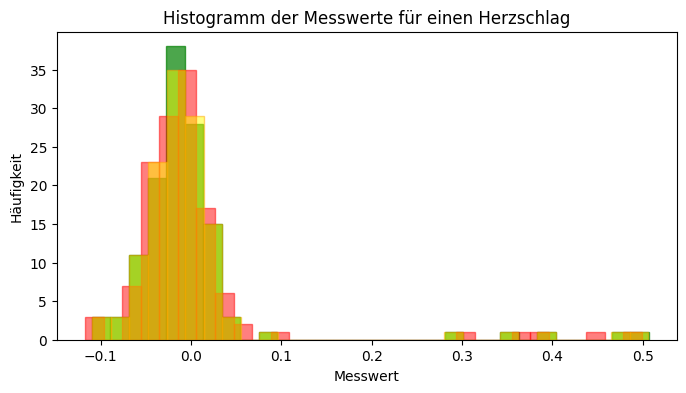

In [26]:
plt.figure(figsize=(8, 4))
plt.hist(ecg_beat, bins=30, color='green', edgecolor='green', alpha=0.7)
plt.hist(ecg_beat_dp_1, bins=30, color='red', edgecolor='red', alpha=0.5)
plt.hist(ecg_beat_dp_2, bins=30, color='yellow', edgecolor='orange', alpha=0.5)
plt.xlabel("Messwert")
plt.ylabel("Häufigkeit")
plt.title("Histogramm der Messwerte für einen Herzschlag")
plt.show()

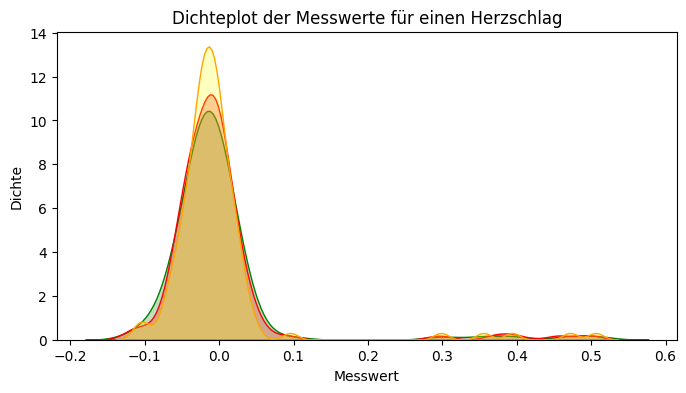

In [27]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ecg_beat, color='green', edgecolor='green', fill=True, bw_adjust=0.7) # blue
sns.kdeplot(ecg_beat_dp_1, color='red', edgecolor='red', fill=True, bw_adjust=0.5) # orange
sns.kdeplot(ecg_beat_dp_2, color='yellow', edgecolor='orange', fill=True, bw_adjust=0.3) # green
plt.xlabel("Messwert")
plt.ylabel("Dichte")
plt.title("Dichteplot der Messwerte für einen Herzschlag")
plt.show()

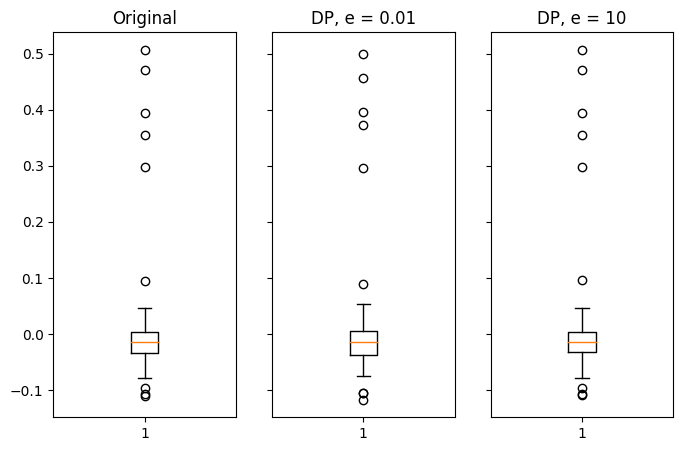

In [28]:
fig, axs = plt.subplots(1, 3, sharey='row', figsize=(8, 5))
axs[0].boxplot(ecg_beat)
axs[0].set_title("Original")
axs[1].boxplot(ecg_beat_dp_1)
axs[1].set_title("DP, e = 0.01")
axs[2].boxplot(ecg_beat_dp_2)
axs[2].set_title("DP, e = 10")
plt.show()

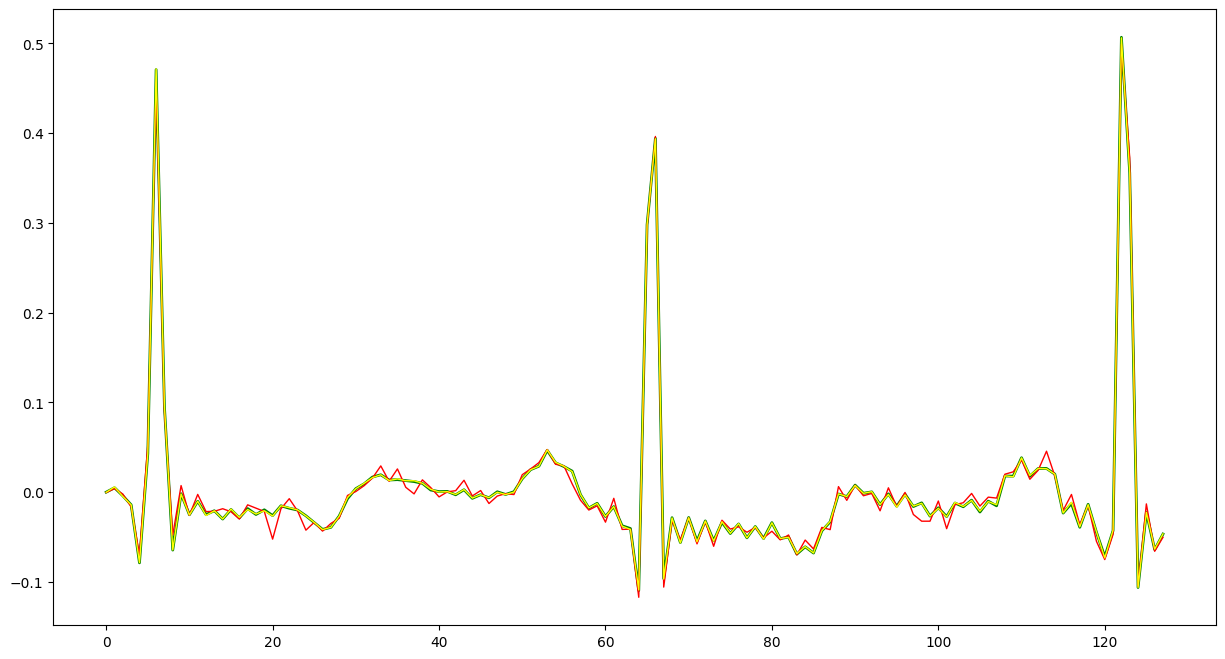

In [29]:
#beat_idx = 0:20

plt.figure(figsize=(15, 8), dpi=100)
plt.plot(ecg_beat, linewidth=2.0, color='green')
plt.plot(ecg_beat_dp_1, linewidth=1.0, color='red')
plt.plot(ecg_beat_dp_2, linewidth=1.0, color='yellow')
#plt.plot(dict_beats[patient_id]['label'][0:20], marker="x", linestyle="", color='green')
#plt.plot(dict_beats_dp[patient_id]['label'][0:20], marker="x", linestyle="", color='red')
plt.show()

## Step 3: Create dictionary and domain adapted training sets

### Functions

In [ ]:
# ---------------------------------------------------------------------------
# Dictionary Functions

def read_5min_beats(s, m): # read dict beats
    with open(osj("..", f"dp_data_{s}", "dataset_beats", f"{m}_5min_normal_beats.pkl"), "rb") as f:
        return pickle.load(f)

def read_25min_beats(s, m): # read data beats
    with open(osj("..", f"dp_data_{s}", "dataset_beats", f"{m}_25min_beats.pkl"), "rb") as f:
        return pickle.load(f)

def ensure_normalized_and_detrended(beats):
    for key in beats.keys():
        b = beats[key]["beats"]
        if not np.allclose(np.linalg.norm(b, axis=1, ord=2), 1):
            raise AssertionError(f"Beats of patient {key} is not normalized.")
            
        p = np.polyfit(np.arange(b.shape[1]), b.T, deg=1)
        if not np.allclose(p, 0):
            raise AssertionError(f"Beats of patient {key} is not detrended.")
        
def generate_dictionary(S, num_atoms=20, delta_err=None, max_it=100, max_admm=100, calc_err=False, seed=0, printing=False):
    """
    Generate a dictionary that represents the signals given in S ∈ (N x F) with sparse keys, minimizing the Lasso loss.
    D ∈ (F x num_atoms).
    X ∈ (num_atoms x N).
    
    Parameters
    ----------
    S : array_like
        Signals to be represented. S ∈ (N x F).
    num_atoms : int
        Number of dictionary elements.
    delta_err : float, default=None
        Stopping criteria for change in error. Stops if the decrease in error is less than (current error * delta_err): 
            Stops if: err(t-1) - err(t) < err(t-1) * delta_err
        Note: calc_err must be true. If calc_err is False, max_it is used. If max_it is reached, we stop regardless.
    """
    assert delta_err is None or calc_err, "Early stopping is not possible without error calculations."  # delta_err implies calc_err
        
    np.random.seed(seed)
    S = S.T  # S ∈ (F x N)
    D = np.random.randn(S.shape[0], num_atoms)
    D = D / np.linalg.norm(D, axis=0, ord=2)
    k = 0
    if calc_err:
        E = np.zeros(max_it)
    
    while k < max_it:
        X = lasso_solver_ADMM(D, S, max_it=max_admm)
        D = S @ np.linalg.pinv(X)  # DX = S  ->  DXX+ = SX+  ->  D = SX+            (Y @ S') \ (S @ S')
        D = D / np.linalg.norm(D, axis=0, ord=2)
        
        if calc_err:
            err = np.linalg.norm((D @ X) - S, ord=2, axis=None)
            E[k] = err
            if k > 1 and delta_err is not None and np.abs(E[k - 1] - E[k]) < E[k - 1] * delta_err:
                if printing:
                    print(f"Stopping early. Abs error diff: {np.abs(E[k - 1] - E[k]):.2e}, Threshold: {E[k - 1] * delta_err:.2e}")
                k = k + 1
                return D, X, E[:k]
            
        k = k + 1
        
    if calc_err:
        return D, X, E
    return D, X

def lasso_solver_ADMM(A, b, max_it=100):
    x = np.zeros((A.shape[1], b.shape[1]))
    z = np.zeros_like(x)
    y = np.zeros_like(x)
    AtA = A.T @ A
    I = np.eye(AtA.shape[0])
    Atb = A.T @ b
    tau_ = 0.08  # one over tau
    lambda_tau = 0.01 / tau_  # lambda * tau
    k = 0
    
    while k < max_it:
        x = np.linalg.solve(AtA + tau_ * I, Atb + tau_ * (z - y))
        z = soft_threshold(x + y, lambda_tau)
        y = y + tau_ * (x - z)
        k = k + 1
        
    return x

def soft_threshold(x, lambda_):
    """
    Implements:
        x - lambda    if x > lambda
        x + lambda    if x < -lambda
        0             otherwise (x in [-lambda, lambda])
    """
    return np.maximum(0, x - lambda_) - np.maximum(0, -lambda_ - x)


def generate_dictionary_pp(patient_ids, dict_beats):

    Ds = {}

    for patient_id in patient_ids:
        dict_beat = dict_beats[patient_id]["beats"]
        D, X, E = generate_dictionary(dict_beat, num_atoms=20, delta_err=None, max_it=20, max_admm=100, calc_err=True, seed=patient_id, printing=True)
        
        # sort D in decreasing order, based on the l1-norm of X's rows.
        sortidx = np.argsort(np.abs(X).sum(axis=1))[::-1]
        D = D[:, sortidx]
        X = X[sortidx, :]
        
        F = spl.null_space(D.T)
        F = spl.orth(F).T
        
        Ds[patient_id] = D
        
    return Ds

def save_dictionary(data, m):
    with open(osj("..", "dp_data_single", "dictionaries", m + "_dictionary.pkl"), "wb") as f:
        pickle.dump(data, f)

# ---------------------------------------------------------------------------
# Domain Adaption Functions

class DomainAdapter():
    def __init__(self):
        self.adapted = False
    
    def adapt(self, Di, Sj, gamma: int, max_it: int=100, max_admm: int=100, plot=False):
        Q = np.eye(Di.shape[0])
        Sj = Sj.T
        
        # Save for speedup
        SjSjT = Sj @ Sj.T
        gSjSjT = gamma * SjSjT

        if plot:
            plt.figure()
        for i in range(max_it):
            QSj = Q @ Sj
            if plot:
                plt.plot(QSj[:, 0], label=f"iter={i}")
            QSj = QSj / np.linalg.norm(QSj, axis=0, ord=2)
            Cj = lasso_solver_ADMM(Di, QSj, max_it=max_admm)
            Q = (Di @ Cj @ Sj.T + gSjSjT) @ np.linalg.pinv(SjSjT + gSjSjT)
            
        if plot:
            plt.legend()
            plt.show()

        self.Q = Q
        self.adapted = True
        return Q
    
    def adapt_gd(self, Di, Sj, gamma: int, lr: float=0.01, max_epochs: int=100, max_admm: int=100, plot=False):
        Q = np.eye(Di.shape[0])
        Sj = Sj.T

        # Save for speedup
        SjSjT = Sj @ Sj.T
        gSjSjT = gamma * SjSjT

        if plot:
            plt.figure()
        for i in range(max_epochs):
            QSj = Q @ Sj
            if plot and i % 10 == 0:
                plt.plot(QSj[:, 0], label=f"iter={i}")
            QSj = QSj / np.linalg.norm(QSj, axis=0, ord=2)
            Cj = lasso_solver_ADMM(Di, QSj, max_it=max_admm)
            
            grad_Q = Q @ SjSjT - Di @ Cj @ Sj.T - gSjSjT + gamma * Q @ SjSjT
            Q = Q - lr * grad_Q
        
        if plot:
            plt.legend()
            plt.show()
        
        self.Q = Q
        self.adapted = True
        return Q
    
    def test(self, Di, Si_D, Si_T, yi, Sj_D, Sj_T, yj, Q, max_it: int=100):
        assert self.adapted, "Call adapt first."
        
        # Fit of i's dictionary beats.
        Ci_D = lasso_solver_ADMM(Di, Si_D.T, max_it=max_it)
        Ei_D = np.linalg.norm((Di @ Ci_D) - Si_D.T, ord=2, axis=0).mean()
        
        # Fit of i's train/test beats.
        Ci_T = lasso_solver_ADMM(Di, Si_T.T, max_it=max_it)
        Ei_T = np.linalg.norm((Di @ Ci_T) - Si_T.T, ord=2, axis=0)
        Ei_T_healthy = Ei_T[yi == "N"].mean()
        Ei_T_arrhyth = Ei_T[yi != "N"].mean()
        
        # Fit of j's dictionary beats on i's dictionary.
        Cj_D = lasso_solver_ADMM(Di, Sj_D.T, max_it=max_it)
        Ej_D = np.linalg.norm((Di @ Cj_D) - Sj_D.T, ord=2, axis=0).mean()
        
        # Fit of j's train/test beats on i's dictionary.
        Cj_T = lasso_solver_ADMM(Di, Sj_T.T, max_it=max_it)
        Ej_T = np.linalg.norm((Di @ Cj_T) - Sj_T.T, ord=2, axis=0)
        Ej_T_healthy = Ej_T[yj == "N"].mean()
        Ej_T_arrhyth = Ej_T[yj != "N"].mean()
        
        # Fit of j's dictionary beats on i's dictionary after domain adaptation.
        QSj_D = Q @ Sj_D.T
        QSj_D = QSj_D / np.linalg.norm(QSj_D, axis=0, ord=2)
        
        DA_Cj_D = lasso_solver_ADMM(Di, QSj_D, max_it=max_it)
        DA_Ej_D = np.linalg.norm((Di @ DA_Cj_D) - QSj_D, ord=2, axis=0).mean()
        
        # Fit of j's train/test beats on i's dictionary after domain adaptation.
        QSj_T = Q @ Sj_T.T
        QSj_T = QSj_T / np.linalg.norm(QSj_T, axis=0, ord=2)
        
        DA_Cj_T = lasso_solver_ADMM(Di, QSj_T, max_it=max_it)
        DA_Ej_T = np.linalg.norm((Di @ DA_Cj_T) - QSj_T, ord=2, axis=0)
        DA_Ej_T_healthy = DA_Ej_T[yj == "N"].mean()
        DA_Ej_T_arrhyth = DA_Ej_T[yj != "N"].mean()
        
        d = {
            "Ei_D": Ei_D, "Ei_T_healthy": Ei_T_healthy, "Ei_T_arrhyth": Ei_T_arrhyth,
            "Ej_D": Ej_D, "Ej_T_healthy": Ej_T_healthy, "Ej_T_arrhyth": Ej_T_arrhyth,
            "DA_Ej_D": DA_Ej_D, "DA_Ej_T_healthy": DA_Ej_T_healthy, "DA_Ej_T_arrhyth": DA_Ej_T_arrhyth
        }
        
        return d
    
def get_patient_adaptation_matrix(Ds, dict_5min, gamma, lr, max_epochs):
    DA = DomainAdapter()
    Q = DA.adapt_gd(Ds, dict_5min["beats"], gamma=gamma, lr=lr, max_epochs=max_epochs)
    return Q

# def get_patient_beat_class_counts():
#     """
#     Finds the number of healthy and arrhythmia beats for each patient.
#     """
#     healthies = []
#     arrhythmias = []
#     for i, patient_id in enumerate(patient_ids):
#         data_beat = data_beats[patient_id]["beats"]
#         data_class = data_beats[patient_id]["class"]
#         num_healthy = np.count_nonzero(data_class == "N")
#         num_arrhyth = np.count_nonzero(data_class != "N")
#         healthies.append(num_healthy)
#         arrhythmias.append(num_arrhyth)
#     # pd.DataFrame(data=[patient_ids, healthies, arrhythmias], index=["patient_id", "num_healthy", "num_arrhythmia"]).T.to_csv("patient_beat_class_counts.csv", index=False)
#     return np.array(healthies), np.array(arrhythmias)

def get_patient_healthy_and_arrhythmia(data_25min, patient_id, healthy_leq_arrhyth=True):
    """
    Returns healthy and arrhythmia beats of patient, where number of healthy returned <= number of arrhythmia returned.
    """
    data_beat = data_25min[patient_id]["beats"]
    data_class = data_25min[patient_id]["class"]
    idx_healthy = np.where(data_class == "N")[0]
    idx_arrhyth = np.where(data_class != "N")[0]
    num_healthy = len(idx_healthy)
    num_arrhyth = len(idx_arrhyth)
    
    if healthy_leq_arrhyth and num_healthy > num_arrhyth:
        num_healthy = num_arrhyth  # take only as much as arrhythmias, maybe try to take all healthies?
    
    healthies = data_beat[idx_healthy[:num_healthy], ...]
    arrhythmias = data_beat[idx_arrhyth[:num_arrhyth], ...]
    return healthies, arrhythmias

def get_patient_train_data(Ds, dict_5min, data_25min, patient_id, valid_patients):
    """
    For patient p, prepare p's train data by getting other patients' healthy and arrhythmia beats + p's dictionary beats. 
    Healthy beats must be <= arrhythmia beats.
    """
    train_X = []
    train_y = []
    train_ids = []
    for i, other_id in enumerate(valid_patients):
        other_healthy, other_arrhyth = get_patient_healthy_and_arrhythmia(data_25min, other_id)
        
        # Ds, beats, i, j, gamma, lr, max_epochs
        Q = get_patient_adaptation_matrix(Ds[patient_id], dict_5min[other_id], gamma=0.2, lr=0.002, max_epochs=25)
        other_healthy = (Q @ other_healthy.T)
        other_healthy = other_healthy / np.linalg.norm(other_healthy, axis=0, ord=2)
        other_healthy = other_healthy.T
        
        other_arrhyth = (Q @ other_arrhyth.T)
        other_arrhyth = other_arrhyth / np.linalg.norm(other_arrhyth, axis=0, ord=2)
        other_arrhyth = other_arrhyth.T
        
        train_X.append(other_healthy)
        train_y.append(np.zeros(len(other_healthy)))
        train_X.append(other_arrhyth)
        train_y.append(np.ones(len(other_arrhyth)))
        train_ids.append(np.ones(len(other_healthy) + len(other_arrhyth)) * other_id)
    dict_beat = dict_5min[patient_id]["beats"]
    train_X.append(dict_beat)
    train_y.append(np.zeros(len(dict_beat)))
    train_ids.append(np.ones(len(dict_beat)) * patient_id)
    
    return np.concatenate(train_X, axis=0), np.concatenate(train_y, axis=0), np.concatenate(train_ids, axis=0)

def get_patient_test_data(data_25min, patient_id):
    """
    For patient p, prepare p's test data from p's 25 minute beats (i.e. beats that are not dictionary beats).
    """
    data_beat = data_25min[patient_id]["beats"]
    data_class = data_25min[patient_id]["class"]
    idx_healthy = np.where(data_class == "N")[0]
    idx_arrhyth = np.where(data_class != "N")[0]
    
    test_X = [data_beat[idx_healthy], data_beat[idx_arrhyth]]
    test_y = [np.zeros(len(idx_healthy)), np.ones(len(idx_arrhyth))]
    test_ids = np.ones(len(idx_healthy) + len(idx_arrhyth)) * patient_id
    
    return np.concatenate(test_X, axis=0), np.concatenate(test_y, axis=0), test_ids

def shuffle(X, y, ids, seed=None):
    """
    Shuffle X, y and ids with the same indices, and optionally set a seed.
    """
    if seed is not None:
        np.random.seed(seed)
    shuffle_idx = np.random.permutation(len(y))
    return X[shuffle_idx], y[shuffle_idx], ids[shuffle_idx]

def train_validation_split(train_X, train_y, train_ids, ratio):
    """
    Train/Validation split by the given ratio, where ratio is size_train / size_all. Keeps the ratio of healthy and arrhythmia beats the same in train and
    validation sets.
    """
    idx_healthy = np.where(train_y == 0)[0]
    idx_arrhyth = np.where(train_y == 1)[0]
    
    num_healthy = len(idx_healthy)
    num_arrhyth = len(idx_arrhyth)
    
    num_train_healthy = int(num_healthy * ratio)
    num_train_arrhyth = int(num_arrhyth * ratio)
    
    num_val_healthy = num_healthy - num_train_healthy
    num_val_arrhyth = num_arrhyth - num_train_arrhyth
    
    val_X = np.concatenate((train_X[idx_healthy[0:num_val_healthy]], train_X[idx_arrhyth[0:num_val_arrhyth]]))
    val_y = np.concatenate((train_y[idx_healthy[0:num_val_healthy]], train_y[idx_arrhyth[0:num_val_arrhyth]]))
    val_ids = np.concatenate((train_ids[idx_healthy[0:num_val_healthy]], train_ids[idx_arrhyth[0:num_val_arrhyth]]))
    
    train_X = np.concatenate((train_X[idx_healthy[num_val_healthy:]], train_X[idx_arrhyth[num_val_arrhyth:]]))
    train_y = np.concatenate((train_y[idx_healthy[num_val_healthy:]], train_y[idx_arrhyth[num_val_arrhyth:]]))
    train_ids = np.concatenate((train_ids[idx_healthy[num_val_healthy:]], train_ids[idx_arrhyth[num_val_arrhyth:]])) 
    
    return train_X, train_y, train_ids, val_X, val_y, val_ids

def generate_patient_datasets(Ds, dict_5min, data_25min, patient_ids):
    """
    Combines all of the functions above to generate datasets for each patient.
    """
    all_patients_dataset = {patient_id:{"train_X":[], "train_y":[], "train_ids":[], "val_X":[], "val_y":[], "val_ids":[], "test_X":[], "test_y":[], "test_ids":[]} for patient_id in patient_ids}

    for i, patient_id in enumerate(patient_ids):

        train_X, train_y, train_ids = get_patient_train_data(Ds, dict_5min, data_25min, patient_id, patient_ids)
        train_X, train_y, train_ids = shuffle(train_X, train_y, train_ids, seed=patient_id)
        
        test_X, test_y, test_ids = get_patient_test_data(data_25min, patient_id)
        test_X, test_y, test_ids = shuffle(test_X, test_y, test_ids, seed=None)
        
        train_X, train_y, train_ids, val_X, val_y, val_ids = train_validation_split(train_X, train_y, train_ids, ratio=0.8)
        train_X, train_y, train_ids = shuffle(train_X, train_y, train_ids, seed=None)
        val_X, val_y, val_ids = shuffle(val_X, val_y, val_ids, seed=None)
        
        all_patients_dataset[patient_id]["train_X"]   = train_X
        all_patients_dataset[patient_id]["train_y"]   = train_y
        all_patients_dataset[patient_id]["train_ids"] = train_ids
        all_patients_dataset[patient_id]["val_X"]     = val_X
        all_patients_dataset[patient_id]["val_y"]     = val_y
        all_patients_dataset[patient_id]["val_ids"]   = val_ids
        all_patients_dataset[patient_id]["test_X"]    = test_X
        all_patients_dataset[patient_id]["test_y"]    = test_y
        all_patients_dataset[patient_id]["test_ids"]  = test_ids

    return all_patients_dataset

def save_domain_adapted(data, setup, m):
    with open(osj("..", f"dp_data_{setup}", "dataset_training", m + "_domain_adapted.pkl"), "wb") as f:
        pickle.dump(data, f)


### Approach

3 Apply domain adaption:
- iterate per method 
    - iterate per epsilon
        - iterate for single & trio 
            - dictionaries - 1 file per patient
            - domain adaption - 1 file per patient

### Code

In [ ]:
# sequential runtime: 60h
# TOTAL runtime per machnism: 19h 
# SINGLE: 1h dictionary + 9h domain adaption
# TRIO: 9h domain adaption

def dictionary_domain_adaption(): 

    valid_patients = pd.read_csv(osj("..", "files", "valid_patients.csv"), header=None).to_numpy().reshape(-1)

    ########  MECHANISM  ########
    for mechanism in p_method:
        logger.info(f" Setup for {mechanism} ...")

        if mechanism == "bounded_n":
            hp_epsilon_values = [0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
                        0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91,
                        1.01, 1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91,
                        2.01, 2.11, 2.21, 2.31, 2.41, 2.51, 2.61, 2.71, 2.81, 2.91,
                        3.01, 3.11, 3.21, 3.31, 3.41, 3.51, 3.61, 3.71, 3.81, 3.91,
                        4.01, 4.11, 4.21, 4.31, 4.41, 4.51, 4.61, 4.71, 4.81, 4.91,
                        5.01, 5.11, 5.21, 5.31, 5.41, 5.51, 5.61, 5.71, 5.81, 5.91,
                        6.01, 6.11, 6.21, 6.31, 6.41, 6.51, 6.61, 6.71, 6.81, 6.91,
                        7.01, 7.11, 7.21, 7.31, 7.41, 7.51, 7.61, 7.71, 7.81, 7.91,
                        8.01, 8.11, 8.21, 8.31, 8.41, 8.51, 8.61, 8.71, 8.81, 8.91,
                        9.01, 9.11, 9.21, 9.31, 9.41, 9.51, 9.61, 9.71, 9.81, 9.91, 10]
        else:
            hp_epsilon_values = [0.00001, 0.0001, 0.001, 
                            0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
                        0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91,
                        1.01, 1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91,
                        2.01, 2.11, 2.21, 2.31, 2.41, 2.51, 2.61, 2.71, 2.81, 2.91,
                        3.01, 3.11, 3.21, 3.31, 3.41, 3.51, 3.61, 3.71, 3.81, 3.91,
                        4.01, 4.11, 4.21, 4.31, 4.41, 4.51, 4.61, 4.71, 4.81, 4.91,
                        5.01, 5.11, 5.21, 5.31, 5.41, 5.51, 5.61, 5.71, 5.81, 5.91,
                        6.01, 6.11, 6.21, 6.31, 6.41, 6.51, 6.61, 6.71, 6.81, 6.91,
                        7.01, 7.11, 7.21, 7.31, 7.41, 7.51, 7.61, 7.71, 7.81, 7.91,
                        8.01, 8.11, 8.21, 8.31, 8.41, 8.51, 8.61, 8.71, 8.81, 8.91,
                        9.01, 9.11, 9.21, 9.31, 9.41, 9.51, 9.61, 9.71, 9.81, 9.91, 10]

        dictionaries_all = {} # = Ds
        
        ########  SETUP  ########
        for setup in p_beats:
            logger.info(f" Loading data for {setup} beats ...")

            dict_5min  = read_5min_beats(setup, mechanism)
            data_25min = read_25min_beats(setup, mechanism)
            domain_adapted_all = {}
            
            ########  EPSILON  DICT ########
            for epsilon in hp_epsilon_values:
                ensure_normalized_and_detrended(dict_5min[epsilon])
                ensure_normalized_and_detrended(data_25min[epsilon])

                if setup == "single": # RUNS 1 hour per machnism
                    logger.info(f"Generate dictionaries for {setup} beats ...")
                    dictionaries_all[epsilon] = generate_dictionary_pp(valid_patients, dict_5min[epsilon])
            
            if setup == "single":
                save_dictionary(dictionaries_all, mechanism)

            ########  EPSILON  DOMAIN ########
            for epsilon in hp_epsilon_values:
                logger.info(f"Starting domain adaption for epsilon {epsilon} ...")
                domain_adapted_e = generate_patient_datasets(Ds=dictionaries_all[epsilon], dict_5min=dict_5min[epsilon], data_25min=data_25min[epsilon], patient_ids=valid_patients) # Takes around 5 minutes to generate all datasets. PER EPSILON
                domain_adapted_all[epsilon] = domain_adapted_e

            logger.info(f"Saving domain adaption for {setup} beats.")
            save_domain_adapted(domain_adapted_all, setup, mechanism)
        
# NEXT: visualize beats + try domain adoption with one mechanism and one epsilon


In [56]:
dictionary_domain_adaption()

INFO:root: Setup for laplace ...
INFO:root: Loading data for single beats ...
INFO:root:Generate dictionaries for single beats ...
INFO:root:Generate dictionaries for single beats ...
INFO:root:Starting domain adaption for epsilon 1e-05 ...
INFO:root:Starting domain adaption for epsilon 10 ...
INFO:root:Saving domain adaption for epsilon 10 ...
INFO:root: Loading data for trio beats ...
INFO:root:Starting domain adaption for epsilon 1e-05 ...
INFO:root:Starting domain adaption for epsilon 10 ...
INFO:root:Saving domain adaption for epsilon 10 ...


## Step 4: Train DA model

### Approach

4 Train net
- iterate per method 
  (patient_cms, cms, models, metrics) - per mechanism
    
    - iterate per epsilon
    (patient_cms, cms, models, metrics) - per epsilon


        - iterate per repeat
            - iterate per patient
            - load N channel input
            - train net
            - store net results per patient
        - get performance (metrics per epsilon)    

### Functions

In [ ]:

def load_domain_data_epsilon(m,e): 
    with open(osj("..", f"dp_data_single", "dataset_training", f"{m}_domain_adapted.pkl"), "rb") as f:
        single = pickle.load(f)
        single_epsilon = single[e]
        del single
    with open(osj("..", f"dp_data_trio", "dataset_training", f"{m}_domain_adapted.pkl"), "rb") as f:
        trio = pickle.load(f)
        trio_epsilon = trio[e]
        del trio
    return single_epsilon, trio_epsilon  


def load_N_channel_dataset(single_data, trio_data):
    """
    Loads the ECG dataset at the given path(s) for one patient at a time. Each dataset will be added as a new
    channel in the given order.
    """
    default_dataset = dataset_to_tensors(single_data)
    dataset_other   = dataset_to_tensors(trio_data)
    default_dataset = add_dataset(default_dataset, dataset_other)
    
    return default_dataset

def dataset_to_tensors(dataset):
    """
    Converts the given dataset to torch tensors in appropriate data types and shapes.
    """
    dataset = dataset.copy()
    train_X, train_y, train_ids, val_X, val_y, val_ids, test_X, test_y, test_ids = dataset.values()
    dataset["train_X"] = torch.Tensor(train_X).float().reshape(-1, 1, train_X.shape[1])
    dataset["train_y"] = torch.Tensor(train_y).long()
    dataset["train_ids"] = torch.Tensor(train_ids).long()
    dataset["val_X"] = torch.Tensor(val_X).float().reshape(-1, 1, val_X.shape[1])
    dataset["val_y"] = torch.Tensor(val_y).long()
    dataset["val_ids"] = torch.Tensor(val_ids).long()
    dataset["test_X"] = torch.Tensor(test_X).float().reshape(-1, 1, test_X.shape[1])
    dataset["test_y"] = torch.Tensor(test_y).long()
    dataset["test_ids"] = torch.Tensor(test_ids).long()
    return dataset

def add_dataset(dataset, dataset_other):
    """
    Adds another dataset to an already existing one, increasing the number of channels.
    """
    dataset = dataset.copy()
    
    assert torch.equal(dataset["train_y"], dataset_other["train_y"]), "Training ground truths are different. Possibly shuffled differently."
    assert torch.equal(dataset["val_y"], dataset_other["val_y"]), "Validation ground truths are different. Possibly shuffled differently."
    assert torch.equal(dataset["test_y"], dataset_other["test_y"]), "Test ground truths are different. Possibly shuffled differently."
    
    train_X, train_y, train_ids, val_X, val_y, val_ids, test_X, test_y, test_ids = dataset.values()
    train_other_X, _, _, val_other_X, _, _, test_other_X, _, _ = dataset_other.values()
    dataset["train_X"] = torch.cat((train_X, train_other_X), dim=1)
    dataset["val_X"] = torch.cat((val_X, val_other_X), dim=1)
    dataset["test_X"] = torch.cat((test_X, test_other_X), dim=1)
    return dataset

def get_base_model(in_channels):
    """
    Returns the model from paper: Personalized Monitoring and Advance Warning System for Cardiac Arrhythmias.
    """
    # Input size: 128x1
    # 128x1 -> 122x32 -> 40x32 -> 34x16 -> 11x16 -> 5x16 -> 1x16
    model = nn.Sequential(
        nn.Conv1d(in_channels, 32, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),
        
        nn.Conv1d(32, 16, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),
        
        nn.Conv1d(16, 16, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),
        
        nn.Flatten(),
        
        nn.Linear(16, 32, bias=True),
        nn.ReLU(),
        
        nn.Linear(32, 2, bias=True),
    )
    return model


# model, mechanism, epsilon, performance, config, net
def save_results_e(model, mechanism, e, p, c, n): 
    e = str(e)
    mechanism = str(mechanism)
    model = str(model)
    try:
        # save performance
        with open(osj("..", "dp_models", model, mechanism, f"{e}_performance.pkl"), "wb") as f:
            pickle.dump(p, f) 
                
        # save config
        with open(osj("..", "dp_models", model, mechanism, f"{e}_config.pkl"), "wb") as f: 
            pickle.dump(c, f) 
            
        # save model
        with open(osj("..", "dp_models", model, mechanism, f"{e}_nets.pkl"), "wb") as f:
            pickle.dump(n, f) 
    except:
        logger.info(f"model: {model}, type: {type(model)}")
        logger.info(f"mechanism: {mechanism}, type: {type(mechanism)}")
        logger.info(f"e: {e}, type: {type(e)}")

### Code

In [ ]:
# if mechanism == "bounded_n":
#         hp_epsilon_values = [0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
#                      0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91,
#                      1.01, 1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91,
#                      2.01, 2.11, 2.21, 2.31, 2.41, 2.51, 2.61, 2.71, 2.81, 2.91,
#                      3.01, 3.11, 3.21, 3.31, 3.41, 3.51, 3.61, 3.71, 3.81, 3.91,
#                      4.01, 4.11, 4.21, 4.31, 4.41, 4.51, 4.61, 4.71, 4.81, 4.91,
#                      5.01, 5.11, 5.21, 5.31, 5.41, 5.51, 5.61, 5.71, 5.81, 5.91,
#                      6.01, 6.11, 6.21, 6.31, 6.41, 6.51, 6.61, 6.71, 6.81, 6.91,
#                      7.01, 7.11, 7.21, 7.31, 7.41, 7.51, 7.61, 7.71, 7.81, 7.91,
#                      8.01, 8.11, 8.21, 8.31, 8.41, 8.51, 8.61, 8.71, 8.81, 8.91,
#                      9.01, 9.11, 9.21, 9.31, 9.41, 9.51, 9.61, 9.71, 9.81, 9.91, 10]
#     else:
#         hp_epsilon_values = [0.00001, 0.0001, 0.001, 
#                            0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
#                      0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91,
#                      1.01, 1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91,
#                      2.01, 2.11, 2.21, 2.31, 2.41, 2.51, 2.61, 2.71, 2.81, 2.91,
#                      3.01, 3.11, 3.21, 3.31, 3.41, 3.51, 3.61, 3.71, 3.81, 3.91,
#                      4.01, 4.11, 4.21, 4.31, 4.41, 4.51, 4.61, 4.71, 4.81, 4.91,
#                      5.01, 5.11, 5.21, 5.31, 5.41, 5.51, 5.61, 5.71, 5.81, 5.91,
#                      6.01, 6.11, 6.21, 6.31, 6.41, 6.51, 6.61, 6.71, 6.81, 6.91,
#                      7.01, 7.11, 7.21, 7.31, 7.41, 7.51, 7.61, 7.71, 7.81, 7.91,
#                      8.01, 8.11, 8.21, 8.31, 8.41, 8.51, 8.61, 8.71, 8.81, 8.91,
#                      9.01, 9.11, 9.21, 9.31, 9.41, 9.51, 9.61, 9.71, 9.81, 9.91, 10]

In [ ]:
def train_net():

    p_method = ["laplace", "bounded_n", "gaussian_a"]
    model = "DA" # training base DA model

    valid_patients = pd.read_csv(osj("..", "files", "valid_patients.csv"), header=None).to_numpy().reshape(-1)
    max_epochs = [-1]
    batch_sizes = [1024]
    repeats = 10

    ########  MECHANISM  ########
    for mechanism in p_method:
        logger.info(f"Setup for {mechanism} ...")

        if mechanism == "bounded_n":
            hp_epsilon_values = [0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
                                0.01, 0.51, 0.91,
                                1.01, 1.51, 1.91,
                                2.01, 2.51, 2.91,
                                3.01, 3.51, 3.91,
                                4.01, 4.51, 4.91,
                                5.01, 5.51, 5.91,
                                6.01, 6.51, 6.91,
                                7.01, 7.51, 7.91,
                                8.01, 8.51, 8.91,
                                9.01, 9.51, 9.91, 10]
        else:
            hp_epsilon_values = [0.00001, 0.0001, 0.001, 
                                0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
                                0.01, 0.51, 0.91,
                                1.01, 1.51, 1.91,
                                2.01, 2.51, 2.91,
                                3.01, 3.51, 3.91,
                                4.01, 4.51, 4.91,
                                5.01, 5.51, 5.91,
                                6.01, 6.51, 6.91,
                                7.01, 7.51, 7.91,
                                8.01, 8.51, 8.91,
                                9.01, 9.51, 9.91, 10]
            

        ########  EPSILON  ########
        for epsilon in hp_epsilon_values:

            if os.path.exists(osj("..", "dp_models", model, mechanism, f"{epsilon}_performance.pkl")):
                logger.info(f"Skipping existing {epsilon} ...")
                
            else:

                single_dataset, trio_dataset = load_domain_data_epsilon(mechanism, epsilon)

                logger.info(f"Starting with epsilon {epsilon} ...")

                epsilon_patient_cms = []
                epsilon_cms = []
                epsilon_net = {}
                epsilon_performance = {}
                
                ########  REPEATS  ########
                for repeat in range(repeats):
                    logger.info(f"Repeat {repeat+1}/10 for epsilon {epsilon}")

                    repeat_patient_cms = {}
                    repeat_net = {}

                    cm = torch.zeros(2, 2)
                    
                    for i, patient_id in enumerate(valid_patients):
                        logger.info(f"Training for patient {patient_id} ...")

                        patient_net = {}
                        dataset = load_N_channel_dataset(single_dataset[patient_id], trio_dataset[patient_id])
                        train_X, train_y, train_ids, val_X, val_y, val_ids, test_X, test_y, test_ids = dataset.values()

                        # Neural Network setup
                        model_base = get_base_model(in_channels=train_X.shape[1])
                        crit = nn.CrossEntropyLoss()
                        optim = torch.optim.AdamW(params=model_base.parameters())
                        net = NeuralNetwork(model_base, optim, crit)
                        weight_checkpoint_val_loss = WeightCheckpoint(tracked="val_loss", mode="min")
                        early_stopping = EarlyStopping(tracked="val_loss", mode="min", patience=15)

                        # Neural Network training
                        net.fit(
                            train_X=train_X,
                            train_y=train_y,
                            validate=True,
                            val_X=val_X,
                            val_y=val_y,
                            max_epochs=max_epochs[0],
                            batch_size=batch_sizes[0],
                            use_cuda=True,
                            fits_gpu=True,
                            callbacks=[weight_checkpoint_val_loss, early_stopping],
                        )
                        
                        net.load_weights(weight_checkpoint_val_loss)
                        pred_y = net.predict(test_X, decision_func=lambda pred_y: pred_y.argmax(dim=1)).cpu()
                        
                        # In order to save the trained weights
                        patient_net = NeuralNetwork.save_class(net) # save best model for this patient, in this repeat
                        repeat_net[patient_id] = patient_net

                        cur_cm = get_confusion_matrix(pred_y, test_y, pos_is_zero=False)
                        repeat_patient_cms[patient_id] = cur_cm # patient_cm
                        cm += cur_cm # 

                    epsilon_net[repeat] = repeat_net

                    epsilon_patient_cms.append(repeat_patient_cms)
                    epsilon_cms.append(cm.detach().clone())  # Konvertiert in eine Python-Liste

                epsilon_cms = np.stack(epsilon_cms).astype(int)
                epsilon_performance = get_performance_metrics(epsilon_cms.sum(axis=0))

                # after all repeats (per epsilon)
                config = dict(
                    learning_rate=0.001,
                    max_epochs=max_epochs[0],
                    batch_size=batch_sizes[0],
                    optimizer=optim.__class__.__name__,
                    loss=crit.__class__.__name__,
                    early_stopping="true",
                    checkpoint_on=weight_checkpoint_val_loss.tracked,
                    dataset="default+trio",
                    info="2-channel run, domain adapted, consulting with default dictionary, and trying all thresholds, saves weights"
                )

                logger.info(f"All repeats for epsilon {epsilon} done. Saving now ...")
                save_results_e(model, mechanism, epsilon, epsilon_performance, config, epsilon_net)

2025-03-15 11:30:37 - INFO - Setup for laplace ...
2025-03-15 11:30:50 - INFO - Starting with epsilon 1e-05 ...
2025-03-15 11:30:50 - INFO - Repeat 1/10 for epsilon 1e-05
2025-03-15 11:30:50 - INFO - Training for patient 100 ...
2025-03-15 11:31:04 - INFO - Training for patient 101 ...
2025-03-15 11:31:15 - INFO - Training for patient 103 ...
2025-03-15 11:31:23 - INFO - Training for patient 106 ...
2025-03-15 11:31:36 - INFO - Training for patient 108 ...
2025-03-15 11:31:49 - INFO - Training for patient 109 ...
2025-03-15 11:32:05 - INFO - Training for patient 111 ...
2025-03-15 11:32:17 - INFO - Training for patient 112 ...
2025-03-15 11:32:32 - INFO - Training for patient 113 ...
2025-03-15 11:32:49 - INFO - Training for patient 115 ...
2025-03-15 11:33:05 - INFO - Training for patient 116 ...
2025-03-15 11:33:19 - INFO - Training for patient 117 ...
2025-03-15 11:33:33 - INFO - Training for patient 118 ...
2025-03-15 11:33:46 - INFO - Training for patient 119 ...
2025-03-15 11:34:

## Step 5: Train Ensemble models

### Functions

In [ ]:
# FUNCTIONS
def load_domain_data_epsilon(m,e): 
    with open(osj("..", f"dp_data_single", "dataset_training", f"{m}_domain_adapted.pkl"), "rb") as f:
        single = pickle.load(f)
        single_epsilon = single[e]
        del single
    with open(osj("..", f"dp_data_trio", "dataset_training", f"{m}_domain_adapted.pkl"), "rb") as f:
        trio = pickle.load(f)
        trio_epsilon = trio[e]
        del trio            
    return single_epsilon, trio_epsilon  

def load_dictionary(m, epsilon, patient_id):
    """
    Reads the pickled ECG dictionary from the given path for the given patient.
    """
    with open(osj("..", "dp_data_single", "dictionaries", f"{m}_dictionary.pkl"), "rb") as f:
        dict_all = pickle.load(f)
        D = dict_all[epsilon][patient_id]
        del dict_all
        F = spl.null_space(D.T)
        F = spl.orth(F).T
    return D, F

def load_net(mechanism, e):
    e = str(e)
    mechanism = str(mechanism)

    with open(osj("..", "dp_models", "DA", mechanism, f"{e}_nets.pkl"), "rb") as f:
        net_e = pickle.load(f)
    return net_e

def extract_array_of_dict_of_confmat(arr):
    return np.stack([np.stack(list(d.values())) for d in arr])

def extract_array_of_dict_of_dict_of_confmat(arr):
    return np.stack([np.stack([np.stack(list(d2.values())) for d2 in d1.values()]) for d1 in arr])

def load_N_channel_dataset(single_data, trio_data):
    """
    Loads the ECG dataset at the given path(s) for one patient at a time. Each dataset will be added as a new
    channel in the given order.
    """
    default_dataset = dataset_to_tensors(single_data)
    dataset_other   = dataset_to_tensors(trio_data)
    default_dataset = add_dataset(default_dataset, dataset_other)
    
    return default_dataset

def dataset_to_tensors(dataset):
    """
    Converts the given dataset to torch tensors in appropriate data types and shapes.
    """
    dataset = dataset.copy()
    train_X, train_y, train_ids, val_X, val_y, val_ids, test_X, test_y, test_ids = dataset.values()
    dataset["train_X"] = torch.Tensor(train_X).float().reshape(-1, 1, train_X.shape[1])
    dataset["train_y"] = torch.Tensor(train_y).long()
    dataset["train_ids"] = torch.Tensor(train_ids).long()
    dataset["val_X"] = torch.Tensor(val_X).float().reshape(-1, 1, val_X.shape[1])
    dataset["val_y"] = torch.Tensor(val_y).long()
    dataset["val_ids"] = torch.Tensor(val_ids).long()
    dataset["test_X"] = torch.Tensor(test_X).float().reshape(-1, 1, test_X.shape[1])
    dataset["test_y"] = torch.Tensor(test_y).long()
    dataset["test_ids"] = torch.Tensor(test_ids).long()
    return dataset

def add_dataset(dataset, dataset_other):
    """
    Adds another dataset to an already existing one, increasing the number of channels.
    """
    dataset = dataset.copy()
    
    assert torch.equal(dataset["train_y"], dataset_other["train_y"]), "Training ground truths are different. Possibly shuffled differently."
    assert torch.equal(dataset["val_y"], dataset_other["val_y"]), "Validation ground truths are different. Possibly shuffled differently."
    assert torch.equal(dataset["test_y"], dataset_other["test_y"]), "Test ground truths are different. Possibly shuffled differently."
    
    train_X, train_y, train_ids, val_X, val_y, val_ids, test_X, test_y, test_ids = dataset.values()
    train_other_X, _, _, val_other_X, _, _, test_other_X, _, _ = dataset_other.values()
    dataset["train_X"] = torch.cat((train_X, train_other_X), dim=1)
    dataset["val_X"] = torch.cat((val_X, val_other_X), dim=1)
    dataset["test_X"] = torch.cat((test_X, test_other_X), dim=1)
    return dataset

def get_base_model(in_channels):
    """
    Returns the model from paper: Personalized Monitoring and Advance Warning System for Cardiac Arrhythmias.
    """
    # Input size: 128x1
    # 128x1 -> 122x32 -> 40x32 -> 34x16 -> 11x16 -> 5x16 -> 1x16
    model = nn.Sequential(
        nn.Conv1d(in_channels, 32, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),
        
        nn.Conv1d(32, 16, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),
        
        nn.Conv1d(16, 16, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),
        
        nn.Flatten(),
        
        nn.Linear(16, 32, bias=True),
        nn.ReLU(),
        
        nn.Linear(32, 2, bias=True),
    )
    return model

def save_results_e(model, mechanism, e, p, c, n): 
        
    # save performance
    with open(osj("..", "dp_models", model, mechanism, f"{e}_performance.pkl"), "rb") as f:
        pickle.dump(p, f) 
            
    # save config
    with open(osj("..", "dp_models", model, mechanism, f"{e}_config.pkl"), "rb") as f: 
        pickle.dump(c, f) 
        
    # save model
    with open(osj("..", "dp_models", model, mechanism, f"{e}_nets.pkl"), "rb") as f:
        pickle.dump(n, f) 

def save_results_ens(model, mechanism, e, perf, cms, config, confs):
    e = str(e)
    mechanism = str(mechanism)
    model = str(model)

    try:
        # save performance
        with open(osj("..", "dp_models", model, mechanism, f"{e}_performance.pkl"), "wb") as f:
            pickle.dump(perf, f) 

        # save cms
        with open(osj("..", "dp_models", model, mechanism, f"{e}_cms.pkl"), "wb") as f: 
            pickle.dump(cms, f) 
                
        # save config
        with open(osj("..", "dp_models", model, mechanism, f"{e}_config.pkl"), "wb") as f: 
            pickle.dump(config, f) 
            
        # save confs
        with open(osj("..", "dp_models", model, mechanism, f"{e}_confs.pkl"), "wb") as f:
            pickle.dump(confs, f) 
    except:
        logger.info(f"model: {model}, type: {type(model)}")
        logger.info(f"mechanism: {mechanism}, type: {type(mechanism)}")
        logger.info(f"e: {e}, type: {type(e)}")

### Code

In [ ]:
# per epsilon: 1 min

def train_ens_model(): 
    p_method = ["laplace", "bounded_n", "gaussian_a"]
    model = "DA_Ens" # training DA Ensemble model

    valid_patients = pd.read_csv(osj("..", "files", "valid_patients.csv"), header=None).to_numpy().reshape(-1)

    max_epochs = [-1]
    batch_sizes = [1024]
    confidences = [0, *np.linspace(0.5, 1, 51)]
    repeats = 10


    ########  MECHANISM  ########
    for mechanism in p_method:
        logger.info(f"Setup {mechanism} for ensemble model ...")

        if mechanism == "bounded_n":
            hp_epsilon_values = [0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
                                0.01, 0.51, 0.91,
                                1.01, 1.51, 1.91,
                                2.01, 2.51, 2.91,
                                3.01, 3.51, 3.91,
                                4.01, 4.51, 4.91,
                                5.01, 5.51, 5.91,
                                6.01, 6.51, 6.91,
                                7.01, 7.51, 7.91,
                                8.01, 8.51, 8.91,
                                9.01, 9.51, 9.91, 10]
        else:
            hp_epsilon_values = [0.00001, 0.0001, 0.001, 
                                0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
                                0.01, 0.51, 0.91,
                                1.01, 1.51, 1.91,
                                2.01, 2.51, 2.91,
                                3.01, 3.51, 3.91,
                                4.01, 4.51, 4.91,
                                5.01, 5.51, 5.91,
                                6.01, 6.51, 6.91,
                                7.01, 7.51, 7.91,
                                8.01, 8.51, 8.91,
                                9.01, 9.51, 9.91, 10]
            
        ########  EPSILON  ########
        for epsilon in hp_epsilon_values:

            if os.path.exists(osj("..", "dp_models", model, mechanism, f"{epsilon}_performance.pkl")):
                logger.info(f"Skipping existing {epsilon} ...")
                
            else:

                if os.path.exists(osj("..", "dp_models", "DA", mechanism, f"{epsilon}_nets.pkl")):

                    single_dataset, trio_dataset = load_domain_data_epsilon(mechanism, epsilon)
                    logger.info(f"Starting with epsilon {epsilon} ...")

                    epsilon_patient_cms = []
                    epsilon_cms = []
                    epsilon_confs = []
                    epsilon_net = {}
                    epsilon_performance = {}

                    nets_all_e = load_net(mechanism, epsilon)

                    ########  REPEATS  ########
                    for repeat in range(repeats):
                        logger.info(f"Repeat {repeat+1}/10 for epsilon {epsilon}")

                        patient_cms = {conf:{} for conf in confidences}
                        cm = {conf:torch.zeros(2, 2) for conf in confidences}
                        repeat_confs = []

                        repeat_patient_cms = {}
                        repeat_net = {}
                        
                        for i, patient_id in enumerate(valid_patients):
                            # logger.info(f"Training for patient {patient_id} ...")
                            dataset = load_N_channel_dataset(single_dataset[patient_id], trio_dataset[patient_id])
                            train_X, train_y, train_ids, val_X, val_y, val_ids, test_X, test_y, test_ids = dataset.values()
                            
                            # For consulting through error energy.
                            D, F = load_dictionary(mechanism, epsilon, patient_id)
                            D, F = torch.Tensor(D), torch.Tensor(F)

                            ## Consulting Exponential - Gaussian.
                            BF = BayesianFit()
                            EF = ExponentialFit()
                            GF = GaussianFit()

                            # Train error.
                            train_E, E_healthy, E_arrhyth = get_error_one_patient(train_X[:, 0, :].squeeze(), F, y=train_y, as_energy=True)
                            # _, E_healthy, E_arrhyth = get_error_per_patient(train_X[:, 0, :].squeeze(), ids=train_ids, DICT_PATH=DICT_PATH, y=train_y, as_energy=True)
                            
                            EF.fit(E_healthy)
                            GF.fit(E_arrhyth)
                            consult_train_y = torch.Tensor(BF.predict(train_E, EF, GF) <= 0.5).long()
                            
                            # Test Error (be careful, we check (<= 0.5) because EF => healthy => label 0)
                            test_E = get_error_one_patient(test_X[:, 0, :].squeeze(), F, as_energy=True)
                            
                            EF.fit(E_healthy)
                            GF.fit(E_arrhyth)
                            consult_test_y = torch.Tensor(BF.predict(test_E, EF, GF) <= 0.5).long()
                            ##

                            # Load the neural network.
                            model_base = get_base_model(in_channels=train_X.shape[1])
                            model_base = model_base.to("cuda")
                            crit = nn.CrossEntropyLoss()
                            optim = torch.optim.AdamW(params=model_base.parameters())
                            
                            net = NeuralNetwork.load_class(nets_all_e[repeat][patient_id], model_base, optim, crit)
                            weight_checkpoint_val_loss = net.cbmanager.callbacks[1]  # <- this needs to change in case weight checkpoint is not the second callback.
                            
                            net.load_weights(weight_checkpoint_val_loss)
                            
                            # Test predictions and probabilities.
                            pred_y = net.predict(test_X, batch_size=1024, use_cuda=True, fits_gpu=True, decision_func=lambda pred_y: pred_y.argmax(dim=1)).cpu()
                            prob_y = net.predict_proba(test_X).cpu()
                            softmax_prob_y = Func.softmax(prob_y, dim=1).max(dim=1).values
                            
                            for conf in confidences:
                                low_confidence = softmax_prob_y < conf
                                high_confidence = softmax_prob_y >= conf

                                final_pred_y = torch.Tensor(np.select([low_confidence, high_confidence], [consult_test_y, pred_y])).long()
                                cm_exp = get_confusion_matrix(final_pred_y, test_y, pos_is_zero=False)

                                patient_cms[conf][patient_id] = cm_exp
                                cm[conf] += cm_exp
                                
                            #print_progress(i + 1, len(valid_patients), opt=[f"{patient_id}"])
                            
                        epsilon_patient_cms.append(repeat_patient_cms)
                        epsilon_cms.append(cm)
                        epsilon_confs.append(repeat_confs)


                    config = dict(
                        learning_rate=0.001,
                        max_epochs=max_epochs[0],
                        batch_size=batch_sizes[0],
                        optimizer=optim.__class__.__name__,
                        loss=crit.__class__.__name__,
                        early_stopping="true",
                        checkpoint_on=weight_checkpoint_val_loss.tracked,
                        dataset="default+trio",
                        info="Results replicated for GitHub, DA + Ensemble + All C."
                    )

                    epsilon_cms = extract_array_of_dict_of_confmat(epsilon_cms)
                    
                    epsilon_performance["DA"]  = get_performance_metrics(epsilon_cms.sum(axis=0)[0])  # only DA
                    epsilon_performance["NPE"] = get_performance_metrics(epsilon_cms.sum(axis=0)[-1]) # only NPE
                    epsilon_performance["ENS"] = get_performance_metrics(epsilon_cms[:, 1:-1, :, :].sum(axis=(0, 1))) # avg over quantized C
                    
                    logger.info(f"All repeats for epsilon {epsilon} done. Saving now ...")
                    save_results_ens(model, mechanism, epsilon, epsilon_performance, epsilon_cms, config, epsilon_confs)
                
                else:

                    logger.info(f"Epsilon {epsilon} was not prepared yet.")

2025-03-18 10:43:54 - INFO - Setup for laplace ...
2025-03-18 10:43:54 - INFO - Skipping existing 1e-05 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.0001 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.001 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.021 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.031 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.041 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.051 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.061 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.071 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.081 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.091 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.01 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.51 ...
2025-03-18 10:43:54 - INFO - Skipping existing 0.91 ...
2025-03-18 10:43:54 - INFO - Skipping existing 1.01 ...
2025-03-18 10:43:54 - INFO - Skipping existing 1.51 ...
2025-03-18 10:43:54 - INFO - Skipping exi

2025-03-18 10:46:27 - INFO - Starting with epsilon 9.51 ...
2025-03-18 10:46:31 - INFO - Repeat 1/10 for epsilon 9.51
2025-03-18 10:46:36 - INFO - Repeat 2/10 for epsilon 9.51
2025-03-18 10:46:41 - INFO - Repeat 3/10 for epsilon 9.51
2025-03-18 10:46:45 - INFO - Repeat 4/10 for epsilon 9.51
2025-03-18 10:46:50 - INFO - Repeat 5/10 for epsilon 9.51
2025-03-18 10:46:54 - INFO - Repeat 6/10 for epsilon 9.51
2025-03-18 10:46:59 - INFO - Repeat 7/10 for epsilon 9.51
2025-03-18 10:47:03 - INFO - Repeat 8/10 for epsilon 9.51
2025-03-18 10:47:08 - INFO - Repeat 9/10 for epsilon 9.51
2025-03-18 10:47:12 - INFO - Repeat 10/10 for epsilon 9.51
2025-03-18 10:47:17 - INFO - All repeats for epsilon 9.51 done. Saving now ...
2025-03-18 10:47:28 - INFO - Starting with epsilon 9.91 ...
2025-03-18 10:47:30 - INFO - Repeat 1/10 for epsilon 9.91
2025-03-18 10:47:35 - INFO - Repeat 2/10 for epsilon 9.91
2025-03-18 10:47:39 - INFO - Repeat 3/10 for epsilon 9.91
2025-03-18 10:47:44 - INFO - Repeat 4/10 for e

In [ ]:
def train_ens_val_model():

    p_method = ["laplace", "bounded_n", "gaussian_a"]
    model = "Ens_val" # training Ensemble validation model

    valid_patients = pd.read_csv(osj("..", "files", "valid_patients.csv"), header=None).to_numpy().reshape(-1)

    max_epochs = [-1]
    batch_sizes = [1024]
    confidences = [0, *np.linspace(0.5, 1, 51)]
    repeats = 10


    ########  MECHANISM  ########
    for mechanism in p_method:
        logger.info(f"Setup {mechanism} for ensemble validation ...")

        if mechanism == "bounded_n":
            hp_epsilon_values = [0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
                                0.01, 0.51, 0.91,
                                1.01, 1.51, 1.91,
                                2.01, 2.51, 2.91,
                                3.01, 3.51, 3.91,
                                4.01, 4.51, 4.91,
                                5.01, 5.51, 5.91,
                                6.01, 6.51, 6.91,
                                7.01, 7.51, 7.91,
                                8.01, 8.51, 8.91,
                                9.01, 9.51, 9.91, 10]
        else:
            hp_epsilon_values = [0.00001, 0.0001, 0.001, 
                                0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
                                0.01, 0.51, 0.91,
                                1.01, 1.51, 1.91,
                                2.01, 2.51, 2.91,
                                3.01, 3.51, 3.91,
                                4.01, 4.51, 4.91,
                                5.01, 5.51, 5.91,
                                6.01, 6.51, 6.91,
                                7.01, 7.51, 7.91,
                                8.01, 8.51, 8.91,
                                9.01, 9.51, 9.91, 10]
            
        ########  EPSILON  ########
        for epsilon in hp_epsilon_values:

            if os.path.exists(osj("..", "dp_models", model, mechanism, f"{epsilon}_performance.pkl")):
                logger.info(f"Skipping existing {epsilon} ...")
                
            else:
                    
                if os.path.exists(osj("..", "dp_models", "DA", mechanism, f"{epsilon}_nets.pkl")):

                    single_dataset, trio_dataset = load_domain_data_epsilon(mechanism, epsilon)
                    logger.info(f"Starting with epsilon {epsilon} ...")

                    epsilon_patient_cms = []
                    epsilon_cms = []
                    epsilon_net = {}
                    epsilon_performance = {}
                    epsilon_confs = []

                    nets_all_e = load_net(mechanism, epsilon)

                    ########  REPEATS  ########
                    for repeat in range(repeats):
                        logger.info(f"Repeat {repeat+1}/10 for epsilon {epsilon}")

                        repeat_patient_cms = {}
                        repeat_net = {}
                        repeat_confs = []
                        cm = torch.zeros(2, 2)
                        
                        for i, patient_id in enumerate(valid_patients):
                            # logger.info(f"Training for patient {patient_id} ...")
                            dataset = load_N_channel_dataset(single_dataset[patient_id], trio_dataset[patient_id])
                            train_X, train_y, train_ids, val_X, val_y, val_ids, test_X, test_y, test_ids = dataset.values()
                            
                            # For consulting through error energy.
                            D, F = load_dictionary(mechanism, epsilon, patient_id)
                            D, F = torch.Tensor(D), torch.Tensor(F)

                            ## Consulting Exponential - Gaussian.
                            BF = BayesianFit()
                            EF = ExponentialFit()
                            GF = GaussianFit()

                            # Train error.
                            train_E, E_healthy, E_arrhyth = get_error_one_patient(train_X[:, 0, :].squeeze(), F, y=train_y, as_energy=True)
                            # _, E_healthy, E_arrhyth = get_error_per_patient(train_X[:, 0, :].squeeze(), ids=train_ids, DICT_PATH=DICT_PATH, y=train_y, as_energy=True)
                            
                            EF.fit(E_healthy)
                            GF.fit(E_arrhyth)
                            consult_train_y = torch.Tensor(BF.predict(train_E, EF, GF) <= 0.5).long()
                                    
                            # Validation error.
                            val_E, val_E_healthy, val_E_arrhyth = get_error_one_patient(val_X[:, 0, :].squeeze(), F, y=val_y, as_energy=True)
                            
                            EF.fit(val_E_healthy)
                            GF.fit(val_E_arrhyth)
                            consult_val_y = torch.Tensor(BF.predict(val_E, EF, GF) <= 0.5).long()
                            
                            # Test Error (be careful, we check (<= 0.5) because EF => healthy => label 0)
                            test_E = get_error_one_patient(test_X[:, 0, :].squeeze(), F, as_energy=True)
                            
                            EF.fit(E_healthy)
                            GF.fit(E_arrhyth)
                            consult_test_y = torch.Tensor(BF.predict(test_E, EF, GF) <= 0.5).long()
                            ##

                            # Load the neural network.
                            model_base = get_base_model(in_channels=train_X.shape[1])
                            model_base = model_base.to("cuda")
                            crit = nn.CrossEntropyLoss()
                            optim = torch.optim.AdamW(params=model_base.parameters())
                            
                            net = NeuralNetwork.load_class(nets_all_e[repeat][patient_id], model_base, optim, crit)
                            weight_checkpoint_val_loss = net.cbmanager.callbacks[1]  # <- this needs to change in case weight checkpoint is not the second callback.
                            
                            net.load_weights(weight_checkpoint_val_loss)
                            
                            # Validation predictions and probabilities.
                            pred_y = net.predict(val_X, batch_size=1024, use_cuda=True, fits_gpu=True, decision_func=lambda pred_y: pred_y.argmax(dim=1)).cpu()
                            prob_y = net.predict_proba(val_X).cpu()
                            softmax_prob_y = Func.softmax(prob_y, dim=1).max(dim=1).values
                            
                            # Choose consult threshold from validation set that maximizes F1.
                            maxF1 = float("-inf")
                            secondMaxF1 = float("-inf")
                            maxConf = -1
                            secondMaxConf = -1
                            for conf in confidences:
                                low_confidence = softmax_prob_y < conf
                                high_confidence = softmax_prob_y >= conf

                                final_pred_y = torch.Tensor(np.select([low_confidence, high_confidence], [consult_val_y, pred_y])).long()
                                val_cm = get_confusion_matrix(final_pred_y, val_y, pos_is_zero=False)
                                f1 = get_performance_metrics(val_cm)["f1"]
                                f1 = np.nan_to_num(f1)
                                
                                if f1 >= (maxF1 - 1e-3):
                                    secondMaxF1 = maxF1
                                    secondMaxConf = maxConf
                                    maxF1 = f1
                                    maxConf = conf
                            
                            repeat_confs.append(maxConf)
                            
                            # Test predictions and probabilities.
                            pred_y = net.predict(test_X, batch_size=1024, use_cuda=True, fits_gpu=True, decision_func=lambda pred_y: pred_y.argmax(dim=1)).cpu()
                            prob_y = net.predict_proba(test_X).cpu()
                            softmax_prob_y = Func.softmax(prob_y, dim=1).max(dim=1).values
                            
                            # Use the confidence chosen above instead of iterating all confidences.
                            for conf in [maxConf]:
                                low_confidence = softmax_prob_y < conf
                                high_confidence = softmax_prob_y >= conf

                                final_pred_y = torch.Tensor(np.select([low_confidence, high_confidence], [consult_test_y, pred_y])).long()
                                cm_exp = get_confusion_matrix(final_pred_y, test_y, pos_is_zero=False)

                                repeat_patient_cms[patient_id] = cm_exp
                                cm += cm_exp
                                
                            #print_progress(i + 1, len(valid_patients), opt=[f"{patient_id}"])
                            
                        epsilon_patient_cms.append(repeat_patient_cms)
                        epsilon_cms.append(cm)
                        epsilon_confs.append(repeat_confs)


                    config = dict(
                        learning_rate=0.001,
                        max_epochs=max_epochs[0],
                        batch_size=batch_sizes[0],
                        optimizer=optim.__class__.__name__,
                        loss=crit.__class__.__name__,
                        early_stopping="true",
                        checkpoint_on=weight_checkpoint_val_loss.tracked,
                        dataset="default+trio",
                        info="Results replicated for GitHub, DA + Ensemble + Validation C."
                    )

                    epsilon_performance = get_performance_metrics(torch.stack(epsilon_cms).sum(dim=0))
                    
                    logger.info(f"All repeats for epsilon {epsilon} done. Saving now ...")
                    save_results_ens(model, mechanism, epsilon, epsilon_performance, epsilon_cms, config, epsilon_confs)

                else:

                    logger.info(f"Epsilon {epsilon} was not prepared yet.")

2025-03-16 13:42:37 - INFO - Setup for laplace ...
2025-03-16 13:42:44 - INFO - Starting with epsilon 1e-05 ...
2025-03-16 13:42:48 - INFO - Repeat 1/10 for epsilon 1e-05
2025-03-16 13:42:48 - INFO - Training for patient 100 ...
2025-03-16 13:42:48 - INFO - Training for patient 101 ...
2025-03-16 13:42:48 - INFO - Training for patient 103 ...
2025-03-16 13:42:48 - INFO - Training for patient 106 ...
2025-03-16 13:42:48 - INFO - Training for patient 108 ...
2025-03-16 13:42:48 - INFO - Training for patient 109 ...
2025-03-16 13:42:49 - INFO - Training for patient 111 ...
2025-03-16 13:42:49 - INFO - Training for patient 112 ...
2025-03-16 13:42:49 - INFO - Training for patient 113 ...
2025-03-16 13:42:49 - INFO - Training for patient 115 ...
2025-03-16 13:42:49 - INFO - Training for patient 116 ...
2025-03-16 13:42:49 - INFO - Training for patient 117 ...
2025-03-16 13:42:50 - INFO - Training for patient 118 ...
2025-03-16 13:42:50 - INFO - Training for patient 119 ...
2025-03-16 13:42:

FileNotFoundError: [Errno 2] No such file or directory: '../dp_models/DA/laplace/2.01_nets.pkl'

## Performance Evaluation

### Functions

In [ ]:
def load_performances(model, mechanism, e):
    with open(osj("..", "dp_models", model, mechanism, f"{e}_performance.pkl"), "rb") as f:
        perf_e = pickle.load(f)
    return perf_e

def load_real_performances(model):
    with open(osj("..", "savefolder", model, f"performance.pkl"), "rb") as f:
        perf_e = pickle.load(f)
    return perf_e

def load_real_shadow_performances(model):
    with open(osj("..", "dp_models", model, "no_dp", "performance.pkl"), "rb") as f:
        perf_e = pickle.load(f)
    return perf_e

### Load performances

In [ ]:
model = ["DA", "DA_Ens", "Ens_val"]
p_method = ["laplace", "bounded_n", "gaussian_a"]
all_performances = {}

# load dp performances
for m in model:
    model_performance = {}

    for mechanism in p_method:
        if mechanism == "bounded_n":
            hp_epsilon_values = [0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
                                0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91,
                                1.01, 1.11, 1.21, 1.31, 1.41, 1.51, 1.91,
                                2.01, 2.51, 2.91,
                                3.01, 3.51, 3.91,
                                4.01, 4.51, 4.91,
                                5.01, 5.51, 5.91,
                                6.01, 6.51, 6.91,
                                7.01, 7.51, 7.91,
                                8.01, 8.51, 8.91,
                                9.01, 9.51, 9.91, 10]
        else:
            hp_epsilon_values = [0.00001, 0.0001, 0.001, 
                                0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091,
                                0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91,
                                1.01, 1.11, 1.21, 1.31, 1.41, 1.51, 1.91,
                                2.01, 2.51, 2.91,
                                3.01, 3.51, 3.91,
                                4.01, 4.51, 4.91,
                                5.01, 5.51, 5.91,
                                6.01, 6.51, 6.91,
                                7.01, 7.51, 7.91,
                                8.01, 8.51, 8.91,
                                9.01, 9.51, 9.91, 10]
            
        mechanism_performance = {}
        
        for epsilon in hp_epsilon_values:
            if os.path.exists(osj("..", "dp_models", m, mechanism, f"{epsilon}_performance.pkl")):   
                perf = load_performances(m, mechanism, epsilon)
                mechanism_performance[epsilon] = perf
            else: 
                logger.info(f"Skipping missing {epsilon} for {mechanism} ...")  

        model_performance[mechanism] = mechanism_performance

    all_performances[m] = model_performance

# load dp shadow performances
for m in model:
    model_performance = {}

    for mechanism in p_method:
        hp_epsilon_values = [0.01, 0.31, 0.41, 0.71, 0.91, 1.01, 1.21, 1.51, 2.01]
        mechanism_performance = {}
        
        for epsilon in hp_epsilon_values:
            if os.path.exists(osj("..", "dp_models", m, mechanism, f"{epsilon}_performance.pkl")):   
                perf = load_performances(m, mechanism, epsilon)
                mechanism_performance[epsilon] = perf
            else: 
                logger.info(f"Skipping missing {epsilon} for {mechanism} ...")  

        model_performance[mechanism] = mechanism_performance

    all_performances[m] = model_performance

# load real performances
for m in model:
    perf = load_real_performances(m)
    all_performances[m]["no_dp"] = perf

# load real shadow performances
model = ["DA_shadow", "Ens_val_shadow"]
for m in model:
    perf = load_real_shadow_performances(m)
    all_performances[m]["no_dp"] = perf


### Plot performances

In [40]:
data = []

for model, mechanisms in all_performances.items():
    for mechanism, epsilons in mechanisms.items():
        if isinstance(epsilons, dict) and all(isinstance(v, dict) for v in epsilons.values()):
            for epsilon, values in epsilons.items():
                if isinstance(values, dict) and all(isinstance(v, dict) for v in values.values()) and epsilon not in ("DA", "NPE", "ENS"):
                    # Case: DA_Ens with Submodels
                    for submodel, metrics in values.items():
                        for metric, value in metrics.items():
                            record = {"Model": submodel, "Method": mechanism, "Epsilon": epsilon, "Metric": metric, "Value": value}
                            data.append(record)
                elif epsilon in ("DA", "NPE", "ENS"):
                    # Case: DA_Ens with Submodels but without epsilon (Real performances)
                    for metric, value in values.items():
                        record = {"Model": epsilon, "Method": mechanism, "Epsilon": None, "Metric": metric, "Value": value}
                        data.append(record)
                else:
                    # Case: without Submodels
                    for metric, value in values.items():
                        record = {"Model": model, "Method": mechanism, "Epsilon": epsilon, "Metric": metric, "Value": value}
                        data.append(record)
        else:
            # Case: Real performances without epsilon
            for metric, value in epsilons.items():
                record = {"Model": model, "Method": mechanism, "Epsilon": None, "Metric": metric, "Value": value}
                data.append(record)

df_performances = pd.DataFrame(data, columns=["Model", "Method", "Epsilon", "Metric", "Value"])


In [41]:
df_performances["Model"].value_counts()

DA         1884
NPE         942
Ens_val     942
ENS         942
Name: Model, dtype: int64

In [42]:
# results for DA are stored twice: once for the initially trained model, and once within the DA_Ens performances
df_performances.drop_duplicates(inplace=True)
df_performances.drop(df_performances[df_performances['Model'] == 'NPE'].index, inplace=True)
df_performances

,Model,Method,Epsilon,Metric,Value
0,DA,laplace,0.00001,acc,0.983752
1,DA,laplace,0.00001,rec,0.984667
2,DA,laplace,0.00001,spe,0.983623
3,DA,laplace,0.00001,pre,0.894569
4,DA,laplace,0.00001,npv,0.997805
...,...,...,...,...,...
4705,Ens_val,no_dp,NaN,rec,0.916363
4706,Ens_val,no_dp,NaN,spe,0.988938
4707,Ens_val,no_dp,NaN,pre,0.921199
4708,Ens_val,no_dp,NaN,npv,0.988206


In [43]:
df_performances["Model"].value_counts()

DA         942
Ens_val    942
ENS        942
Name: Model, dtype: int64

In [44]:
np.set_printoptions(suppress=True) 
df_performances["Epsilon"].unique()

array([ 0.00001,  0.0001 ,  0.001  ,  0.021  ,  0.031  ,  0.041  ,
        0.051  ,  0.061  ,  0.071  ,  0.081  ,  0.091  ,  0.01   ,
        0.11   ,  0.21   ,  0.31   ,  0.41   ,  0.51   ,  0.61   ,
        0.71   ,  0.81   ,  0.91   ,  1.01   ,  1.11   ,  1.21   ,
        1.31   ,  1.41   ,  1.51   ,  1.91   ,  2.01   ,  2.51   ,
        2.91   ,  3.01   ,  3.51   ,  3.91   ,  4.01   ,  4.51   ,
        4.91   ,  5.01   ,  5.51   ,  5.91   ,  6.01   ,  6.51   ,
        6.91   ,  7.01   ,  7.51   ,  7.91   ,  8.01   ,  8.51   ,
        8.91   ,  9.01   ,  9.51   ,  9.91   , 10.     ,      nan])

### Plot: F1 vs Epsilon for DA model

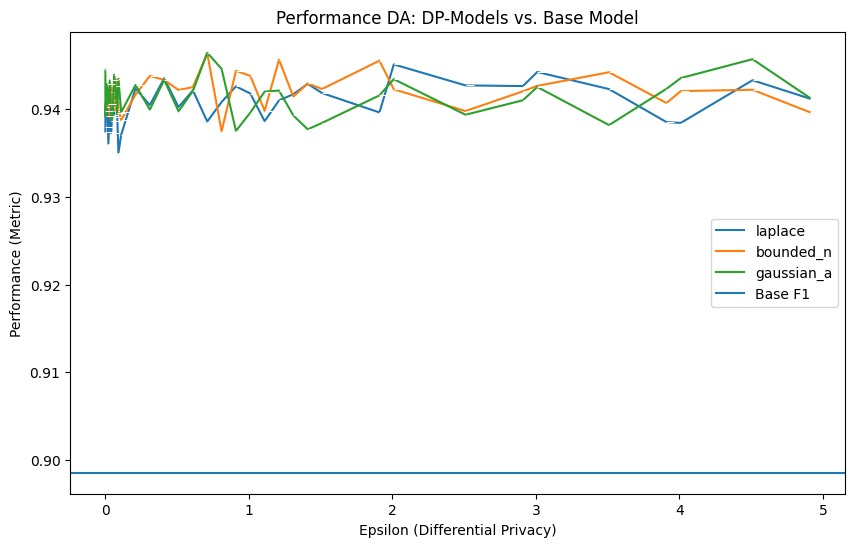

In [45]:
df_f1_da     = df_performances[(df_performances["Metric"] == "f1") & (df_performances["Model"] == "DA")]
dp_perf_da   = df_f1_da[df_f1_da["Epsilon"] <= 5]
real_perf_da = df_f1_da[df_f1_da["Method"] == "no_dp"]["Value"].values[0]

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=dp_perf_da,
    x="Epsilon", 
    y="Value", 
    hue="Method", 
    marker=True
)

plt.axhline(y=real_perf_da, linestyle="-", label=f"Base F1")
# plt.xscale("log") 
plt.xlabel("Epsilon (Differential Privacy)")
plt.ylabel("Performance (Metric)")
plt.title("Performance DA: DP-Models vs. Base Model")
plt.legend()
plt.show()

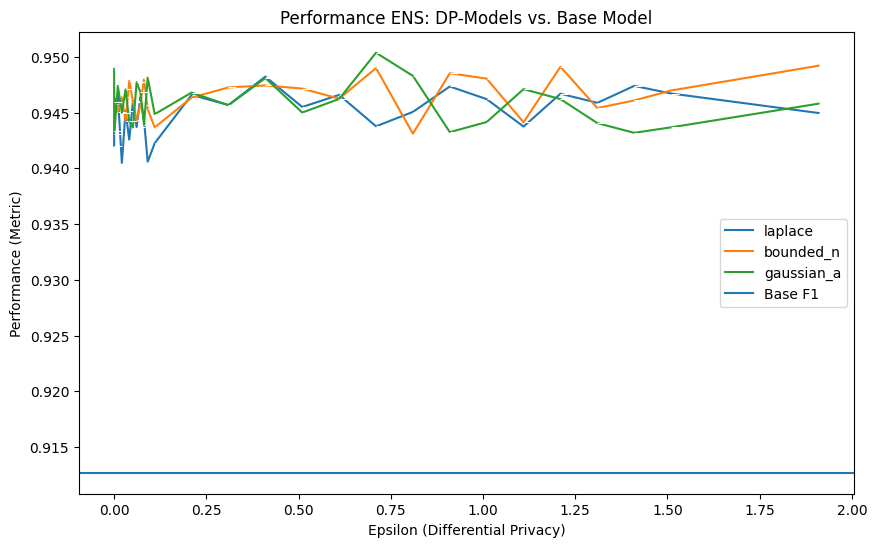

In [46]:
df_f1_ens      = df_performances[(df_performances["Metric"] == "f1") & (df_performances["Model"] == "ENS")]
dp_perf_ens   = df_f1_ens[df_f1_ens["Epsilon"] <= 2]
real_perf_ens = df_f1_ens[df_f1_ens["Method"] == "no_dp"]["Value"].values[0]

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=dp_perf_ens,
    x="Epsilon", 
    y="Value", 
    hue="Method", 
    marker=True
)

plt.axhline(y=real_perf_ens, linestyle="-", label=f"Base F1")
# plt.xscale("log") 
plt.xlabel("Epsilon (Differential Privacy)")
plt.ylabel("Performance (Metric)")
plt.title("Performance ENS: DP-Models vs. Base Model")
plt.legend()
plt.show()

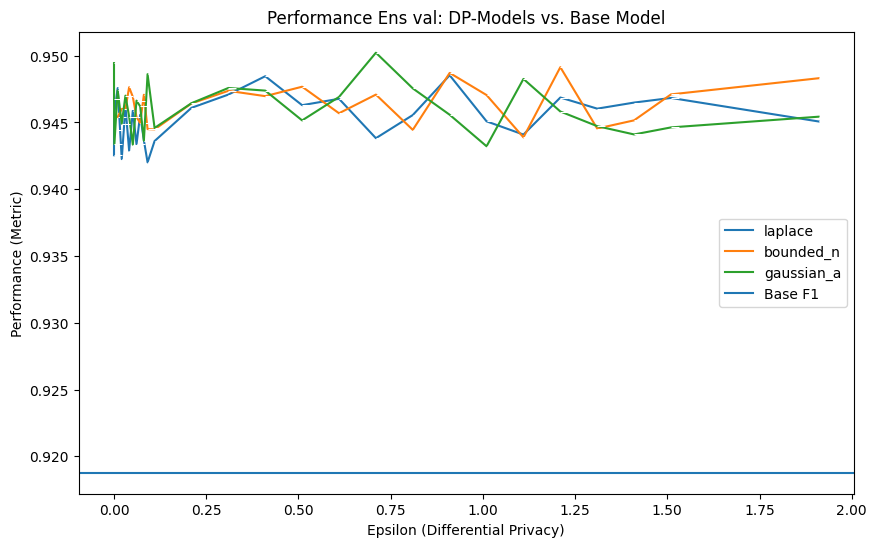

In [47]:
df_f1_val     = df_performances[(df_performances["Metric"] == "f1") & (df_performances["Model"] == "Ens_val")]
dp_perf_val   = df_f1_val[df_f1_val["Epsilon"] <= 2]
real_perf_val = df_f1_val[df_f1_val["Method"] == "no_dp"]["Value"].values[0]

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=dp_perf_val,
    x="Epsilon", 
    y="Value", 
    hue="Method", 
    marker=True
)

plt.axhline(y=real_perf_val, linestyle="-", label=f"Base F1")
# plt.xscale("log") 
plt.xlabel("Epsilon (Differential Privacy)")
plt.ylabel("Performance (Metric)")
plt.title("Performance Ens val: DP-Models vs. Base Model")
plt.legend()
plt.show()

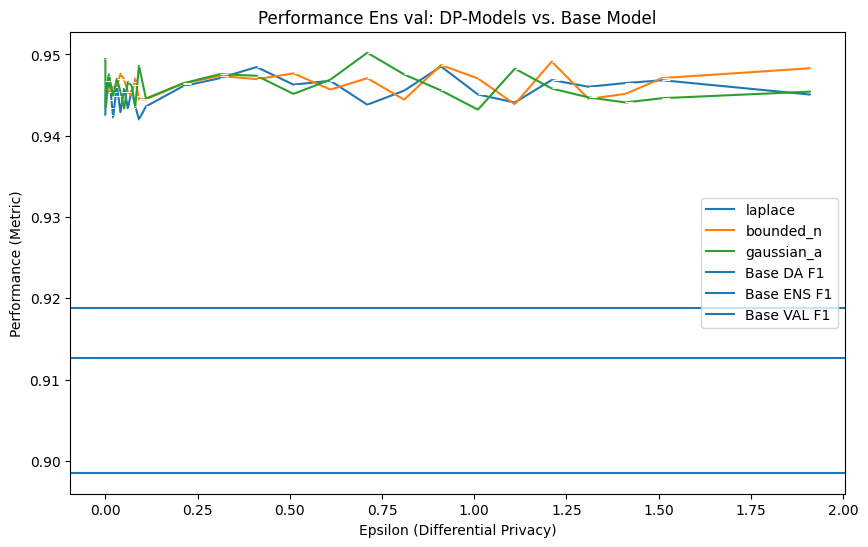

In [48]:

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=dp_perf_val,
    x="Epsilon", 
    y="Value", 
    hue="Method", 
    marker=True
)

plt.axhline(y=real_perf_da, linestyle="-", label=f"Base DA F1")
plt.axhline(y=real_perf_ens, linestyle="-", label=f"Base ENS F1")
plt.axhline(y=real_perf_val, linestyle="-", label=f"Base VAL F1")
# plt.xscale("log") 
plt.xlabel("Epsilon (Differential Privacy)")
plt.ylabel("Performance (Metric)")
plt.title("Performance Ens val: DP-Models vs. Base Model")
plt.legend()
plt.show()

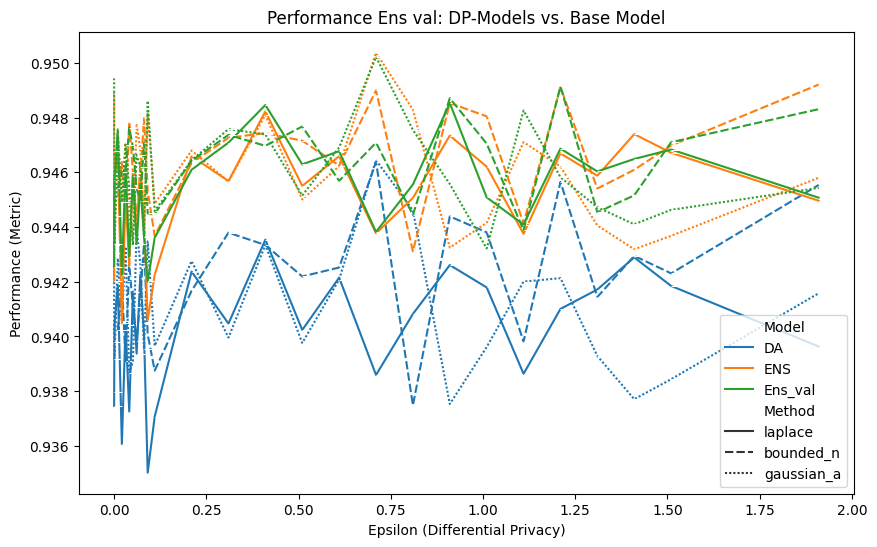

In [49]:
df_f1_dp = df_performances[(df_performances["Metric"] == "f1") & (df_performances["Epsilon"] <= 2)]

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_f1_dp,
    x="Epsilon", 
    y="Value", 
    hue="Model", 
    style="Method",
    marker=True
)

# plt.xscale("log") 
plt.xlabel("Epsilon (Differential Privacy)")
plt.ylabel("Performance (Metric)")
plt.title("Performance Ens val: DP-Models vs. Base Model")
plt.legend()
plt.show()

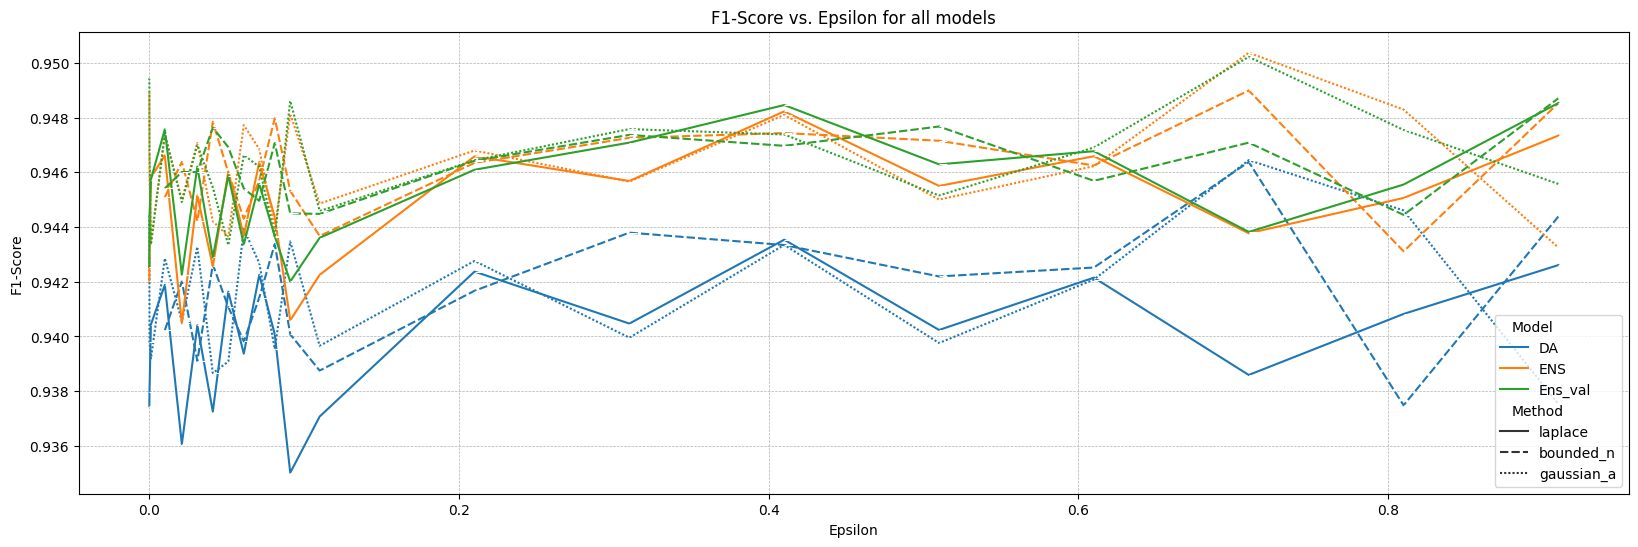

In [ ]:
df_f1 = df_performances[(df_performances["Metric"] == "f1") & (df_performances["Epsilon"] <= 1)] 

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_f1, x="Epsilon", y="Value", hue="Model", style="Method", marker=True, dashes=True)

# plt.xscale("log")
plt.xlabel("Epsilon")
plt.ylabel("F1-Score")
plt.title("F1-Score vs. Epsilon for all models")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

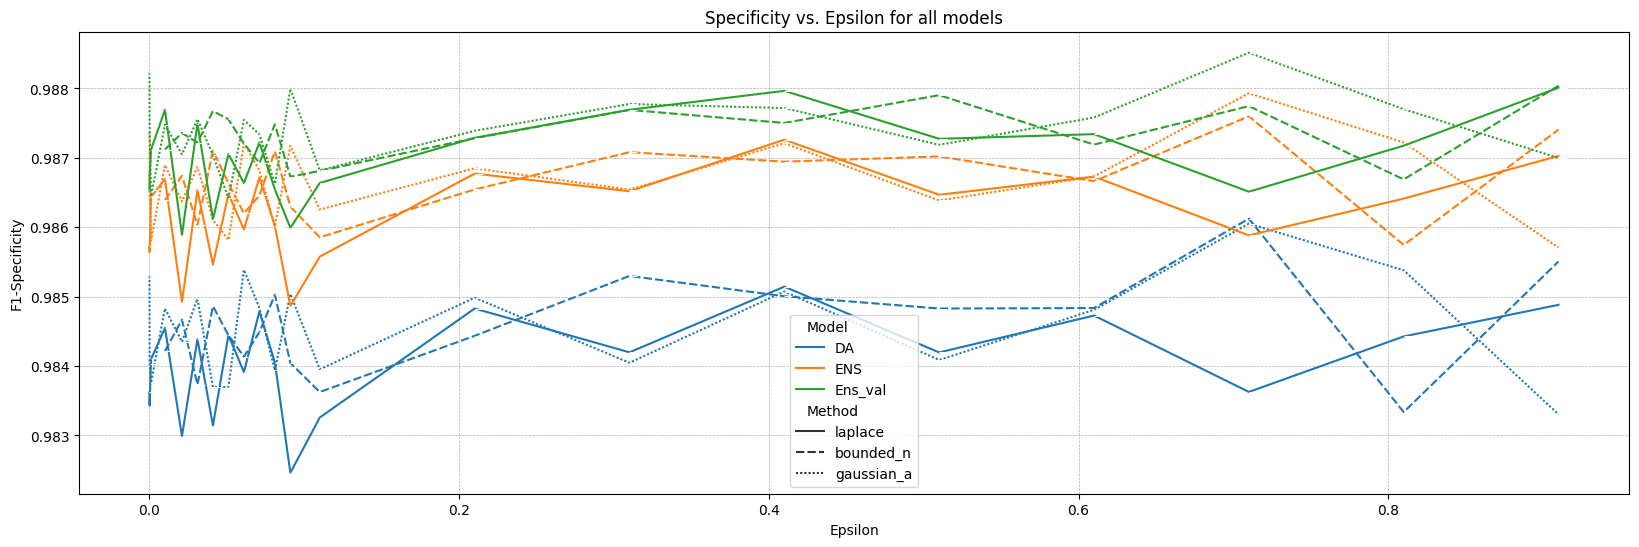

In [ ]:
df_spe = df_performances[(df_performances["Metric"] == "spe") & (df_performances["Epsilon"] <= 1)] 

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_spe, x="Epsilon", y="Value", hue="Model", style="Method", marker=True, dashes=True)

# plt.xscale("log")
plt.xlabel("Epsilon")
plt.ylabel("Specificity")
plt.title("Specificity vs. Epsilon for all models")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

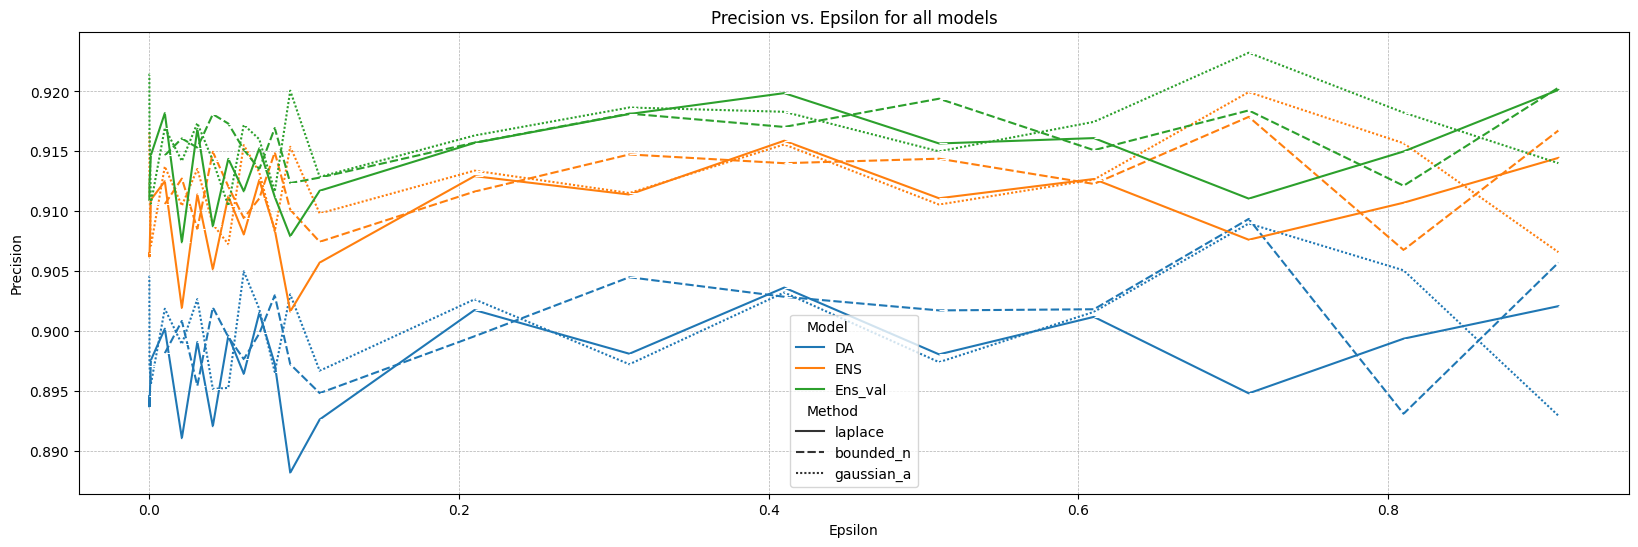

In [59]:
df_pre = df_performances[(df_performances["Metric"] == "pre") & (df_performances["Epsilon"] <= 1)] 

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_pre, x="Epsilon", y="Value", hue="Model", style="Method", marker=True, dashes=True)

# plt.xscale("log")
plt.xlabel("Epsilon")
plt.ylabel("Precision")
plt.title("Precision vs. Epsilon for all models")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

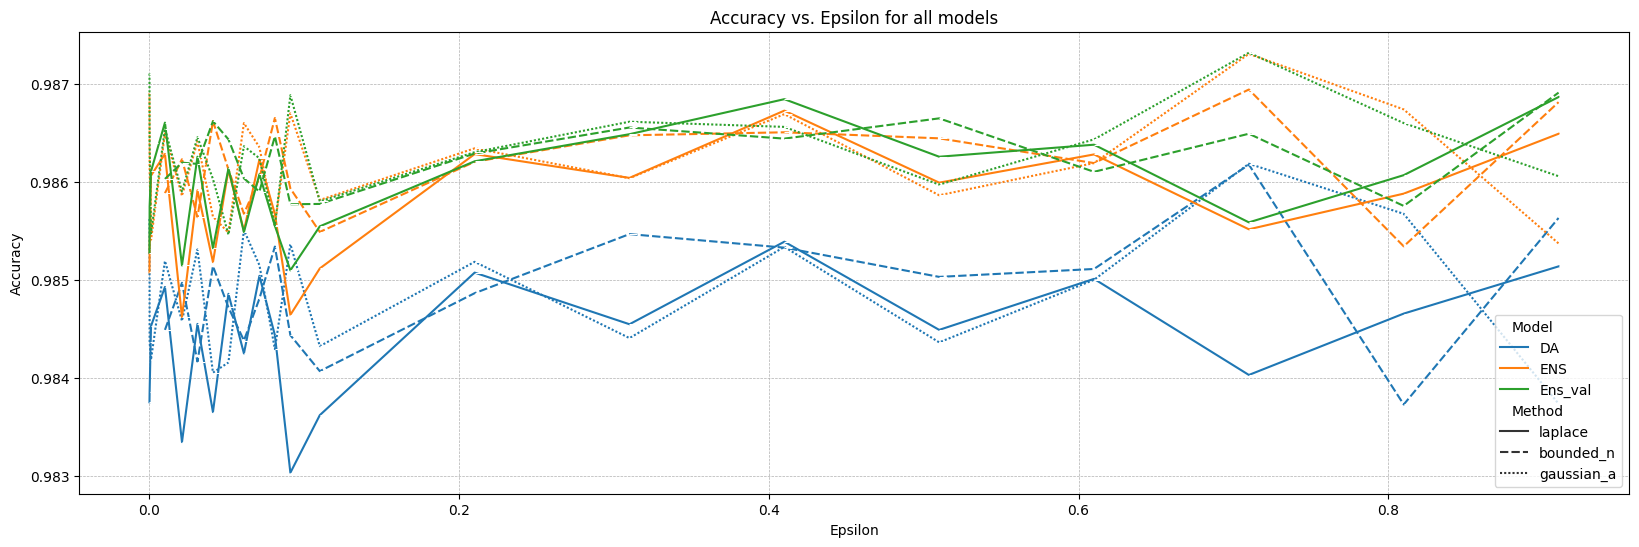

In [60]:
df_acc = df_performances[(df_performances["Metric"] == "acc") & (df_performances["Epsilon"] <= 1)] 

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_acc, x="Epsilon", y="Value", hue="Model", style="Method", marker=True, dashes=True)

# plt.xscale("log")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epsilon for all models")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

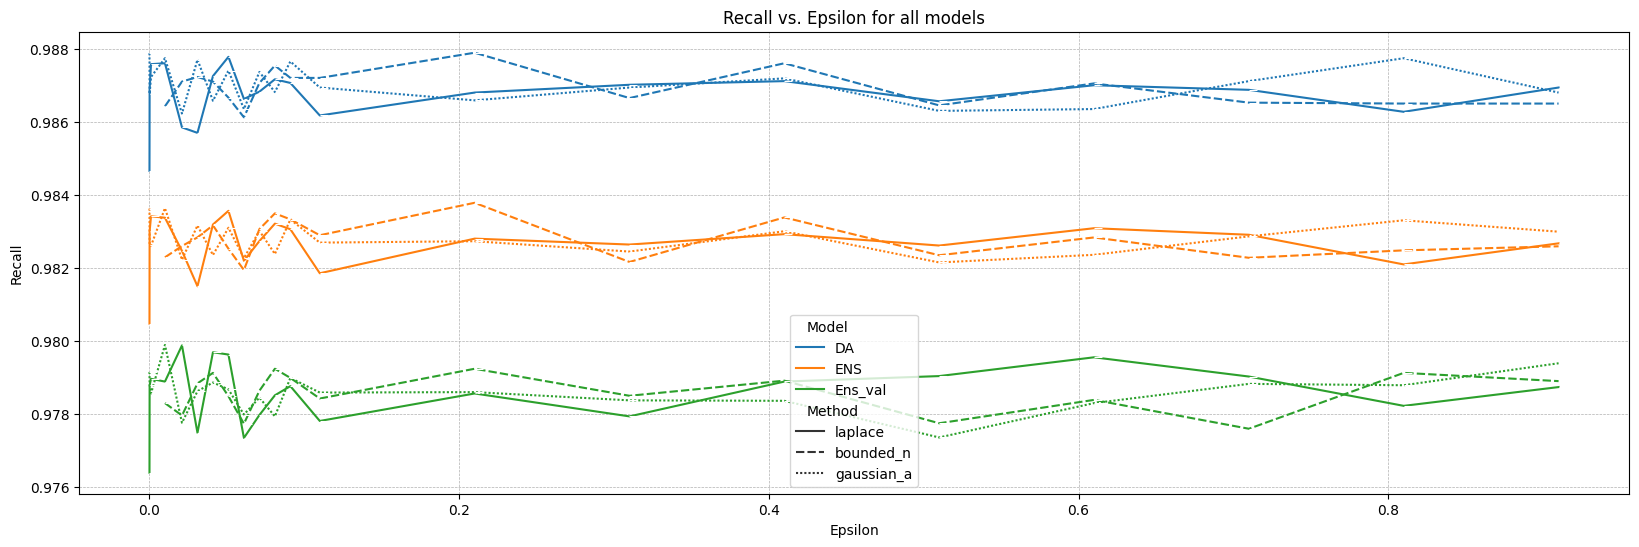

In [61]:
df_rec = df_performances[(df_performances["Metric"] == "rec") & (df_performances["Epsilon"] <= 1)] 

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_rec, x="Epsilon", y="Value", hue="Model", style="Method", marker=True, dashes=True)

# plt.xscale("log")
plt.xlabel("Epsilon")
plt.ylabel("Recall")
plt.title("Recall vs. Epsilon for all models")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

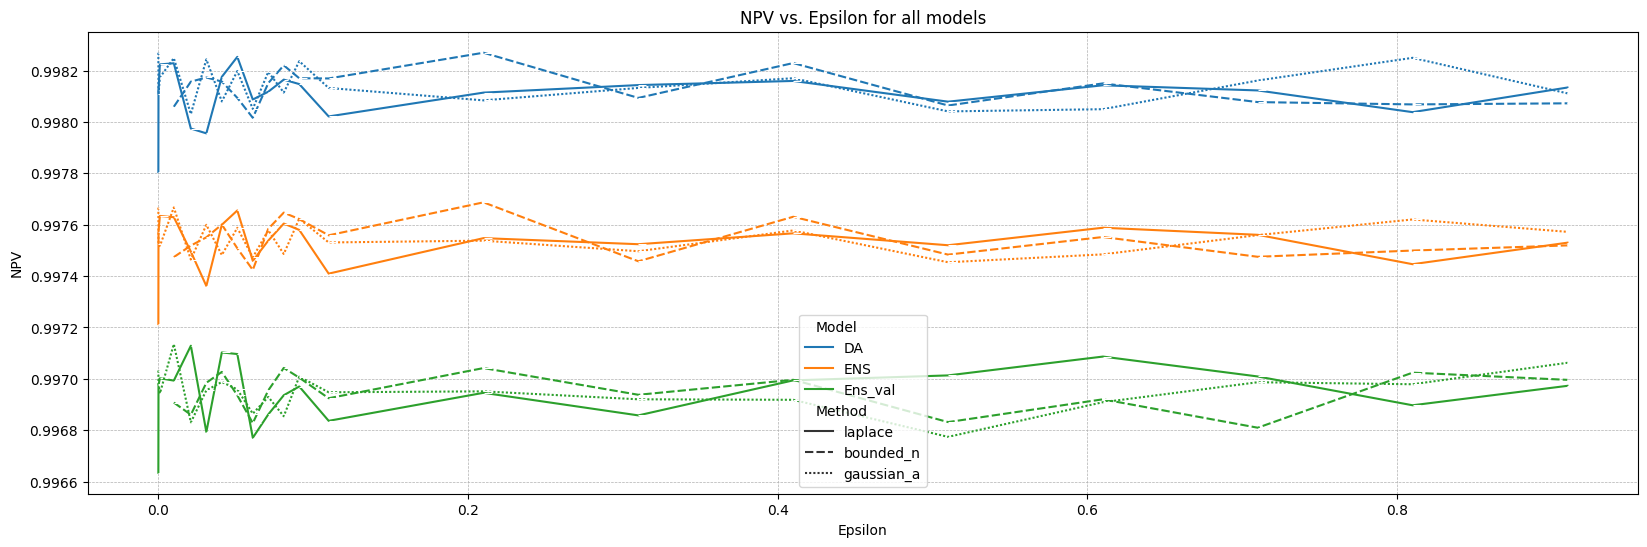

In [62]:
df_npv = df_performances[(df_performances["Metric"] == "npv") & (df_performances["Epsilon"] <= 1)] 

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_npv, x="Epsilon", y="Value", hue="Model", style="Method", marker=True, dashes=True)

# plt.xscale("log")
plt.xlabel("Epsilon")
plt.ylabel("NPV")
plt.title("NPV vs. Epsilon for all models")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

### Performance Distribution across methods

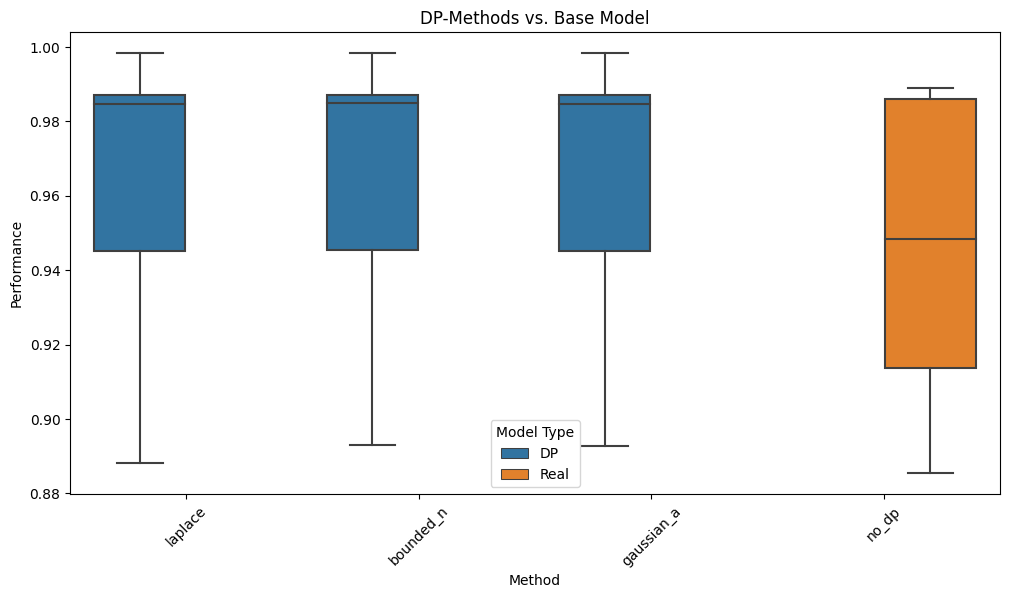

In [51]:
df_f1 = df_performances[(df_performances["Metric"] == "f1")] 

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_performances, x="Method", y="Value", hue=df_performances["Epsilon"].isna().map({True: "Real", False: "DP"}))
plt.ylabel("Performance")
plt.xlabel("Method")
plt.title("DP-Methods vs. Base Model")
plt.xticks(rotation=45)
plt.legend(title="Model Type")
plt.show()

### Epsilon - Performance Correlation

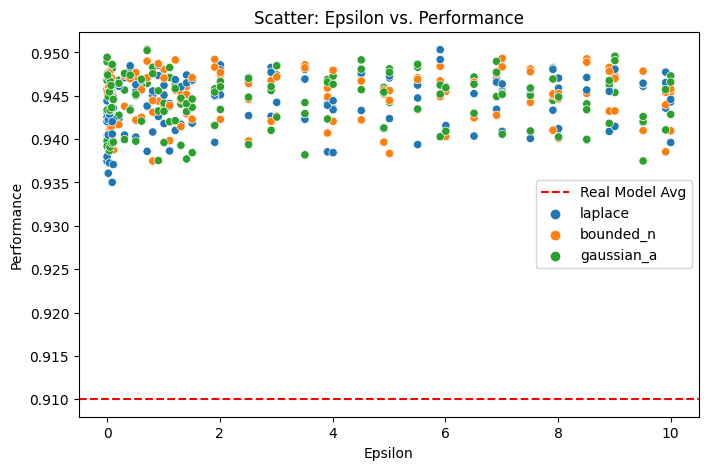

In [52]:
df_f1 = df_performances[(df_performances["Metric"] == "f1")] 

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_f1[df_f1["Epsilon"].notna()],
    x="Epsilon",
    y="Value",
    hue="Method"
)

plt.axhline(df_f1[df_f1["Epsilon"].isna()]["Value"].mean(), linestyle="--", color="red", label="Real Model Avg")
# plt.xscale("log")
plt.xlabel("Epsilon")
plt.ylabel("Performance")
plt.title("Scatter: Epsilon vs. Performance")
plt.legend()
plt.show()

### Heatmap for performance of dp methods

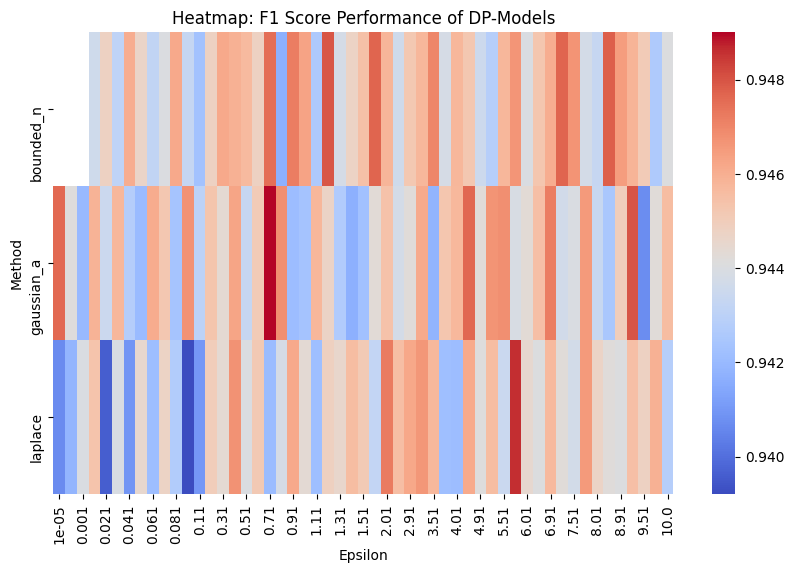

In [64]:
df_f1 = df_performances[(df_performances["Metric"] == "f1")] 

pivot_table = df_f1.pivot_table(values="Value", index="Method", columns="Epsilon")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap="coolwarm", annot=False, fmt=".2f")
plt.xlabel("Epsilon")
plt.ylabel("Method")
plt.title("Heatmap: F1 Score Performance of DP-Models")
plt.show()

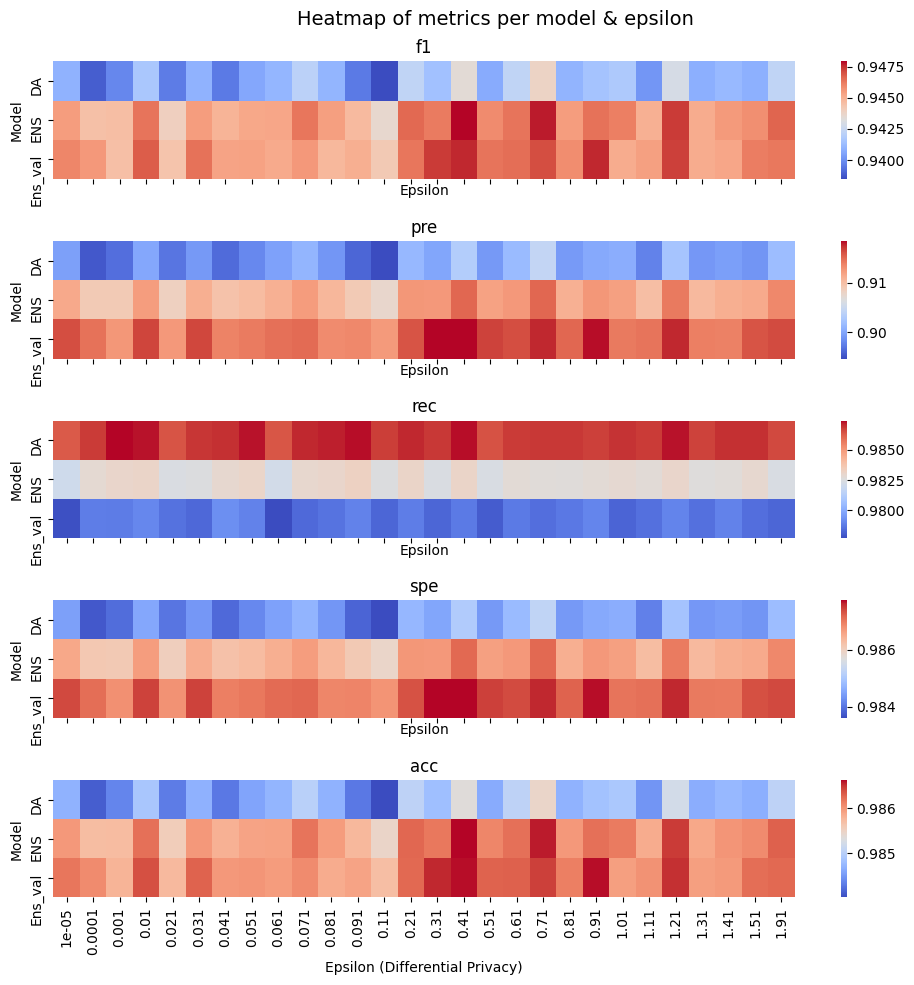

In [74]:
metrics_of_interest = ["f1", "pre", "rec", "spe", "acc"]
df_selected = df_performances[(df_performances["Metric"].isin(metrics_of_interest)) & (df_performances["Epsilon"] <= 2)]

# df_pivot = df_selected.pivot_table(index=["Method", "Metric"], columns="Epsilon", values="Value", aggfunc="mean")

# plt.figure(figsize=(12, 6))
# sns.heatmap(df_pivot, cmap="coolwarm", annot=False, cbar=True)
# plt.xlabel("Epsilon (Differential Privacy)")
# plt.ylabel("Model & Metric")
# plt.title("Heatmap der Metriken pro Model & Epsilon")
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.show()

fig, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True, sharey=True)  # 5 rows, same axes

for i, metric in enumerate(metrics_of_interest):  
    df_pivot = df_selected[df_selected["Metric"] == metric].pivot_table(index="Model", columns="Epsilon", values="Value", aggfunc="mean")
    
    vmin = df_pivot.min().min()
    vmax = df_pivot.max().max()
    
    sns.heatmap(df_pivot, cmap="coolwarm", annot=False, cbar=True, ax=axes[i], vmin=vmin, vmax=vmax)
    
    axes[i].set_title(metric)
    if i == 4:
        axes[i].set_ylabel("Model") 
        axes[i].set_xlabel("Epsilon (Differential Privacy)")

plt.suptitle("Heatmap of metrics per model & epsilon", fontsize=14)
plt.tight_layout()
plt.show()


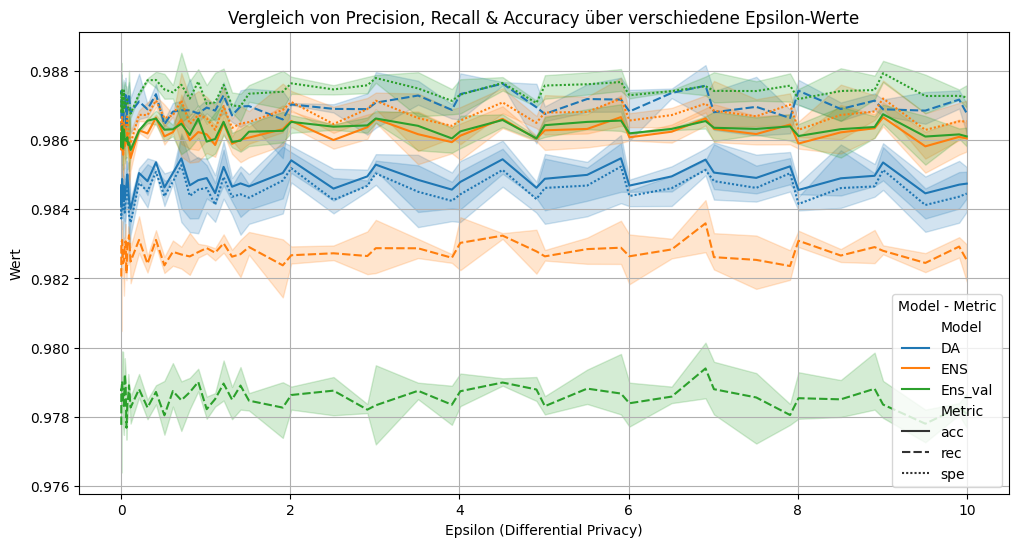

In [ ]:
# metrics_of_interest = ["pre", "rec", "spe", "acc"]
metrics_of_interest = ["rec", "spe", "acc"]
df_selected = df_performances[(df_performances["Metric"].isin(metrics_of_interest))]

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_selected, 
    x="Epsilon", 
    y="Value", 
    hue="Model", 
    style="Metric", 
    dashes=True
)

# plt.xscale("log") 
plt.xlabel("Epsilon (Differential Privacy)")
plt.ylabel("Value")
plt.title("Precision, Recall & Accuracy per Epsilon")
plt.grid(True)
plt.show()


## Step 6: Train Attack Models

### 6.1 Membership Inference Attack

#### 6.1 A - Train Shadow Models


- get test data from original model
- get view trainings data (leaked data) 20%
- train test split (80/20)

- for each mechanism and given epsilon
        - train and test shadowmodel

#### 6.1 B - Train Attack Model

##### Functions

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# LOAD DATA
def load_train_test_data(m, e):
    with open(osj("..", "dp_models", "train_test_data", m, f"{e}_data.pkl"), "rb") as f:
        data = pickle.load(f)
    return data 

def load_real_train_test_data():
    with open(osj("..", "dp_models", "train_test_data", "real_data.pkl"), "rb") as f:
        data = pickle.load(f)
    return data

# LOAD PROBS
def load_dp_probs(model, mechanism, e):
    with open(osj("..", "dp_models", model, mechanism, f"{e}_probs.pkl"), "rb") as f:
        probs = pickle.load(f)
    return probs

def load_real_probs(model, mechanism):
    with open(osj("..", "dp_models", model, mechanism, "probs.pkl"), "rb") as f:
        probs = pickle.load(f)
    return probs

def save_attack_performance(attack, metrics):    
    with open(osj("..", "dp_models", "attacks", f"{attack}_performance.pkl"), "wb") as f:
        pickle.dump(metrics, f) 

def load_attack_performance(attack):    
    with open(osj("..", "dp_models", "attacks", f"{attack}_performance.pkl"), "rb") as f:
        metrics = pickle.load(f) 
    return metrics
    

##### MIA Attack model

In [ ]:
# runs ~1 minute 

def train_real_mia():

    # define setup
    attack = "MIA" 
    models = ["DA_shadow", "Ens_val_shadow"]
    mechanism = "no_dp"

    # load data
    data  = load_real_train_test_data() # X

    model_metrics = {}

    for model in models:
        probs = load_real_probs(model, mechanism) # y

        test_dict = {}
        train_dict = {}
        mechanism_metrics = {}

        # extract data for attack model training
        for patient_id in data.keys():
            # label = 0 for data used for testing
            test_dict[patient_id] = {
                "probs": probs[patient_id]["test"],
                "labels": np.zeros(len(data[patient_id]["Test_x"]))
            }

            if model == "Ens_val_shadow":    
                # label = 1 for data used for training (train + val)
                train_dict[patient_id] = {
                    "probs": np.concatenate([probs[patient_id]["train"], probs[patient_id]["val"]]),
                    "labels": np.ones(len(data[patient_id]["Val_x"]))
                }
            else: 
                # label = 1 for data used for training
                train_dict[patient_id] = {
                    "probs": probs[patient_id]["train"],
                    "labels": np.ones(len(data[patient_id]["Val_x"]))
                }


        # Create flat dictionary for probs and labels only
        flat_dict = {"probs": [], "labels": []}

        for patient_id, values in test_dict.items():
            flat_dict["probs"].extend(values["probs"])
            flat_dict["labels"].extend(values["labels"])

        for patient_id, values in train_dict.items():
            flat_dict["probs"].extend(values["probs"])
            flat_dict["labels"].extend(values["labels"])

        X = flat_dict["probs"]
        y = flat_dict["labels"]

        # final data split for training the MIA model
        X_attack_train, X_attack_test, y_attack_train, y_attack_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        X_attack_train = np.array(X_attack_train).reshape(-1, 1)
        X_attack_test  = np.array(X_attack_test).reshape(-1, 1)

        # Random Forest as MIA model
        attacker_model = RandomForestClassifier(n_estimators=100, random_state=42)
        attacker_model.fit(X_attack_train, y_attack_train)

        y_pred = attacker_model.predict(X_attack_test)

        acc = accuracy_score(y_attack_test, y_pred)
        pre, rec, f1, _ = precision_recall_fscore_support(y_attack_test, y_pred, average="binary")

        metrics = {"acc":acc, "rec":rec, "pre":pre, "f1":f1}
        mechanism_metrics[mechanism] = metrics
        model_metrics[model] = mechanism_metrics

    save_attack_performance(attack, model_metrics)


In [ ]:
# model_metrics

# {'DA_shadow': {'no_dp': {'acc': 0.5808620007908264,
#    'rec': 0.7059352967648382,
#    'pre': 0.6412317754462461,
#    'f1': 0.672029702970297}},
#  'Ens_val_shadow': {'no_dp': {'acc': 0.585850290476625,
#    'rec': 0.7154857742887144,
#    'pre': 0.6435349673937486,
#    'f1': 0.677605720509542}}}

{'DA_shadow': {'no_dp': {'acc': 0.5808620007908264,
   'rec': 0.7059352967648382,
   'pre': 0.6412317754462461,
   'f1': 0.672029702970297}},
 'Ens_val_shadow': {'no_dp': {'acc': 0.585850290476625,
   'rec': 0.7154857742887144,
   'pre': 0.6435349673937486,
   'f1': 0.677605720509542}}}

In [8]:
#def train_dp_mia():

# define setup
attack = "MIA" 
models = ["DA_shadow", "Ens_val_shadow"]
p_method = ["laplace", "bounded_n", "gaussian_a"]
hp_epsilon_values = [0.31, 0.41, 0.71, 0.91, 1.21]

# model_metrics = {}
model_metrics = load_attack_performance(attack)

for model in models:
    for mechanism in p_method:
        epsilon_metrics = {}
        for epsilon in hp_epsilon_values:

            try: 
                model_metrics[model][mechanism][epsilon]
                logger.info(f"Skipping existing epsilon {epsilon} for {mechanism} in {model}...")

            except KeyError:
            
                data  = load_train_test_data(mechanism, epsilon) # X
                probs = load_dp_probs(model, mechanism, epsilon) # y

                test_dict = {}
                train_dict = {}
                
                # extract data for attack model training
                for patient_id in data.keys():
                    # label = 0 for data used for testing
                    test_dict[patient_id] = {
                        "probs": probs[patient_id]["test"],
                        "labels": np.zeros(len(data[patient_id]["Test_x"]))
                    }

                    if model == "Ens_val_shadow":    
                        # label = 1 for data used for training (train + val)
                        train_dict[patient_id] = {
                            "probs": np.concatenate([probs[patient_id]["train"], probs[patient_id]["val"]]),
                            "labels": np.ones(len(data[patient_id]["Val_x"]))
                        }
                    else: 
                        # label = 1 for data used for training
                        train_dict[patient_id] = {
                            "probs": probs[patient_id]["train"],
                            "labels": np.ones(len(data[patient_id]["Val_x"]))
                        }

                # Create flat dictionary for probs and labels only
                flat_dict = {"probs": [], "labels": []}

                for patient_id, values in test_dict.items():
                    flat_dict["probs"].extend(values["probs"])
                    flat_dict["labels"].extend(values["labels"])

                for patient_id, values in train_dict.items():
                    flat_dict["probs"].extend(values["probs"])
                    flat_dict["labels"].extend(values["labels"])

                X = flat_dict["probs"]
                y = flat_dict["labels"]

                # final data split for training the MIA model
                X_attack_train, X_attack_test, y_attack_train, y_attack_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

                X_attack_train = np.array(X_attack_train).reshape(-1, 1)
                X_attack_test  = np.array(X_attack_test).reshape(-1, 1)

                # Random Forest as MIA model
                logger.info(f"Training random forest MIA model for epsilon {epsilon}, {mechanism}, {model}...")
                attacker_model = RandomForestClassifier(n_estimators=100, random_state=42)
                attacker_model.fit(X_attack_train, y_attack_train)

                y_pred = attacker_model.predict(X_attack_test)

                acc = accuracy_score(y_attack_test, y_pred)
                pre, rec, f1, _ = precision_recall_fscore_support(y_attack_test, y_pred, average="binary")

                metrics = {"acc":acc, "rec":rec, "pre":pre, "f1":f1}

                epsilon_metrics[epsilon] = metrics

        if epsilon_metrics != {}:
            model_metrics[model][mechanism] = epsilon_metrics

save_attack_performance(attack, model_metrics)
logger.info(f"Saved updated attack performance for {attack}.")


2025-03-23 21:09:32 - INFO - Skipping existing epsilon 0.31 for laplace in DA_shadow...
2025-03-23 21:09:32 - INFO - Skipping existing epsilon 0.41 for laplace in DA_shadow...
2025-03-23 21:09:32 - INFO - Skipping existing epsilon 0.71 for laplace in DA_shadow...
2025-03-23 21:09:32 - INFO - Skipping existing epsilon 0.91 for laplace in DA_shadow...
2025-03-23 21:09:32 - INFO - Skipping existing epsilon 1.21 for laplace in DA_shadow...
2025-03-23 21:09:32 - INFO - Skipping existing epsilon 0.31 for bounded_n in DA_shadow...
2025-03-23 21:09:32 - INFO - Skipping existing epsilon 0.41 for bounded_n in DA_shadow...
2025-03-23 21:09:32 - INFO - Skipping existing epsilon 0.71 for bounded_n in DA_shadow...
2025-03-23 21:09:32 - INFO - Skipping existing epsilon 0.91 for bounded_n in DA_shadow...
2025-03-23 21:09:32 - INFO - Skipping existing epsilon 1.21 for bounded_n in DA_shadow...
2025-03-23 21:19:15 - INFO - Saved updated attack performance for MIA.


In [9]:
model_metrics

{'DA_shadow': {'no_dp': {'acc': 0.5808620007908264,
   'rec': 0.7059352967648382,
   'pre': 0.6412317754462461,
   'f1': 0.672029702970297},
  'laplace': {0.31: {'acc': 0.5895903672054738,
    'rec': 0.739109319605653,
    'pre': 0.6453377432896578,
    'f1': 0.6890478562050075},
   0.41: {'acc': 0.5956556813767965,
    'rec': 0.7275023068330824,
    'pre': 0.6540913457339971,
    'f1': 0.6888464810429265},
   0.71: {'acc': 0.5934446801517822,
    'rec': 0.7368753338837356,
    'pre': 0.6494735039808236,
    'f1': 0.6904193115373239},
   0.91: {'acc': 0.5861842301831546,
    'rec': 0.7418289543975524,
    'pre': 0.6415641144105171,
    'f1': 0.6880630630630632},
   1.21: {'acc': 0.5932355313872538,
    'rec': 0.7369724636977321,
    'pre': 0.6492534120566466,
    'f1': 0.6903375489036485}},
  'bounded_n': {0.31: {'acc': 0.5878275419044489,
    'rec': 0.7303676363459763,
    'pre': 0.6459496606820719,
    'f1': 0.6855697125794908},
   0.41: {'acc': 0.5877080283247184,
    'rec': 0.74450

In [ ]:
mia_perf = load_attack_performance("MIA")

#### 6.1 C - Performance Analysis

In [4]:
mia_perf = load_attack_performance("MIA")
data = []

for model in mia_perf.keys():
    for mechanism in mia_perf[model].keys():
        if mechanism == "no_dp":
            for metric, value in mia_perf[model][mechanism].items():
                record = {"Model": model, "Method": mechanism, "Epsilon": None, "Metric": metric, "Value": value}
                data.append(record)
        else:
            for epsilon, metrics in mia_perf[model][mechanism].items():
                for metric, value in mia_perf[model][mechanism][epsilon].items():
                    record = {"Model": model, "Method": mechanism, "Epsilon": epsilon, "Metric": metric, "Value": value}
                    data.append(record)

df_mia_perf = pd.DataFrame(data, columns=["Model", "Method", "Epsilon", "Metric", "Value"])


In [5]:
df_mia_perf

,Model,Method,Epsilon,Metric,Value
0,DA_shadow,no_dp,NaN,acc,0.580862
1,DA_shadow,no_dp,NaN,rec,0.705935
2,DA_shadow,no_dp,NaN,pre,0.641232
3,DA_shadow,no_dp,NaN,f1,0.672030
4,DA_shadow,laplace,0.31,acc,0.589590
...,...,...,...,...,...
123,Ens_val_shadow,gaussian_a,0.91,f1,0.684028
124,Ens_val_shadow,gaussian_a,1.21,acc,0.589710
125,Ens_val_shadow,gaussian_a,1.21,rec,0.738429
126,Ens_val_shadow,gaussian_a,1.21,pre,0.645620


In [6]:
df_mia_perf["Model"].value_counts()

Ens_val_shadow    64
DA_shadow         64
Name: Model, dtype: int64

In [ ]:
np.set_printoptions(suppress=True) 
df_mia_perf["Epsilon"].unique()

array([ nan, 0.31, 0.41, 0.71, 0.91, 1.21])

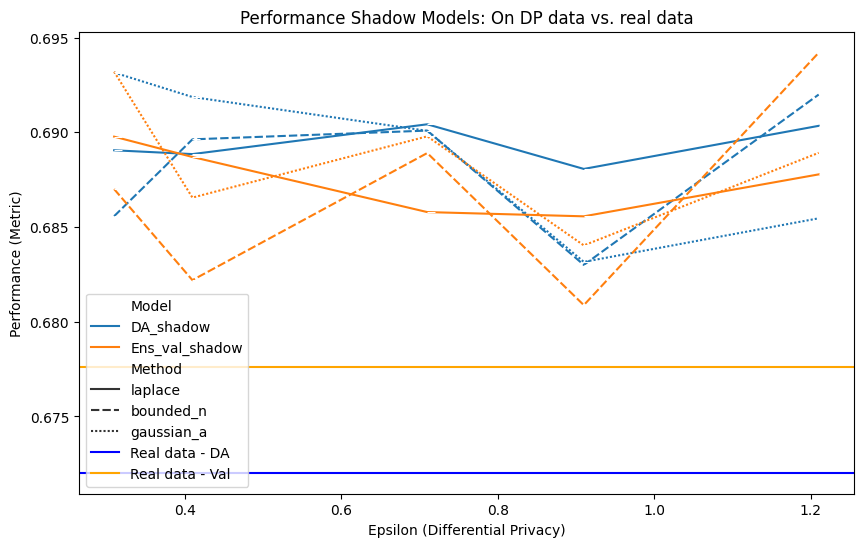

In [13]:
df_f1_mia     = df_mia_perf[(df_mia_perf["Metric"] == "f1")]
dp_perf_mia   = df_f1_mia[df_f1_mia["Epsilon"] >= 0]
real_perf_mia_da  = df_f1_mia[(df_f1_mia["Method"] == "no_dp") & (df_f1_mia["Model"] == "DA_shadow")]["Value"].values[0]
real_perf_mia_val = df_f1_mia[(df_f1_mia["Method"] == "no_dp") & (df_f1_mia["Model"] == "Ens_val_shadow")]["Value"].values[0]

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=dp_perf_mia,
    x="Epsilon", 
    y="Value", 
    hue="Model",
    style="Method", 
    marker=True
)

plt.axhline(y=real_perf_mia_da, linestyle="-", label=f"Real data - DA", color="blue")
plt.axhline(y=real_perf_mia_val, linestyle="-", label=f"Real data - Val", color="orange")
# plt.xscale("log") 
plt.xlabel("Epsilon (Differential Privacy)")
plt.ylabel("Performance (Metric)")
plt.title("Performance Shadow Models: On DP data vs. real data")
plt.legend()
plt.show()